<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

__Uses large gridsearch at end__

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import svm
from sklearn.linear_model import SGDRegressor, LogisticRegression, LogisticRegressionCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error, r2_score
from sklearn.metrics import recall_score, classification_report, explained_variance_score
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFECV


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# Setting global parameters for plots.
params = {'legend.fontsize': 'x-large',
          'figure.figsize':(15,10),
         'axes.labelsize': 15,
         'axes.titlesize':20,
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
plt.rcParams.update(params)


In [3]:
# Ignore warnings for readability
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
# Load the data
house = pd.read_csv('../housing.csv')

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

### EDA

In [5]:
# A:
house.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [6]:
# LotFrontage      1201 non-null float64    Linear feet of street connected to property  
# Alley            91 non-null object       No alley access
# MasVnrType       1452 non-null object     no veneer
# MasVnrArea       1452 non-null float64    "    "
# BsmtQual         1423 non-null object     Evaluates the height of the basement         No basement
# BsmtCond         1423 non-null object     General condition of the basement            "     "
# BsmtExposure     1422 non-null object     No = no exposure, maybe that is counted as Null
# BsmtFinType1     1423 non-null object
# BsmtFinType2     1422 non-null object     check for the different missing value
# Electrical       1459 non-null object     check that 1 row
# FireplaceQu      770 non-null object      no fireplace
# GarageType       1379 non-null object      no garage
# GarageYrBlt      1379 non-null float64     ""
# GarageFinish     1379 non-null object      
# GarageQual       1379 non-null object
# GarageCond       1379 non-null object
# PoolQC           7 non-null object          no pool
# Fence            281 non-null object       no fence
# MiscFeature      54 non-null object        no feature

# Basic look at data and why the null values are null


In [7]:
house['KitchenAbvGr'].value_counts()

1    1392
2      65
3       2
0       1
Name: KitchenAbvGr, dtype: int64

In [8]:
house = house[house['MSZoning'].str.contains('F|R')] # Only get Residential

In [9]:
# House built in 2010, cant get prediction from that
house.drop(index=378, inplace=True)

In [10]:
# Fill NAN for ints
house[['MasVnrArea','LotFrontage']] = house[['MasVnrArea','LotFrontage']].fillna(value=0) 

In [11]:
# Fill NAN for objects as None
house[['MasVnrType','BsmtExposure','GarageType']] = house[['MasVnrType','BsmtExposure','GarageType']].fillna(value='None')

In [12]:
house['MSZoning'].value_counts()

RL    1150
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

In [13]:
house['Exterior1st'].value_counts()

VinylSd    514
HdBoard    222
MetalSd    215
Wd Sdng    204
Plywood    107
CemntBd     61
BrkFace     49
WdShing     26
Stucco      25
AsbShng     19
Stone        2
BrkComm      2
CBlock       1
ImStucc      1
AsphShn      1
Name: Exterior1st, dtype: int64

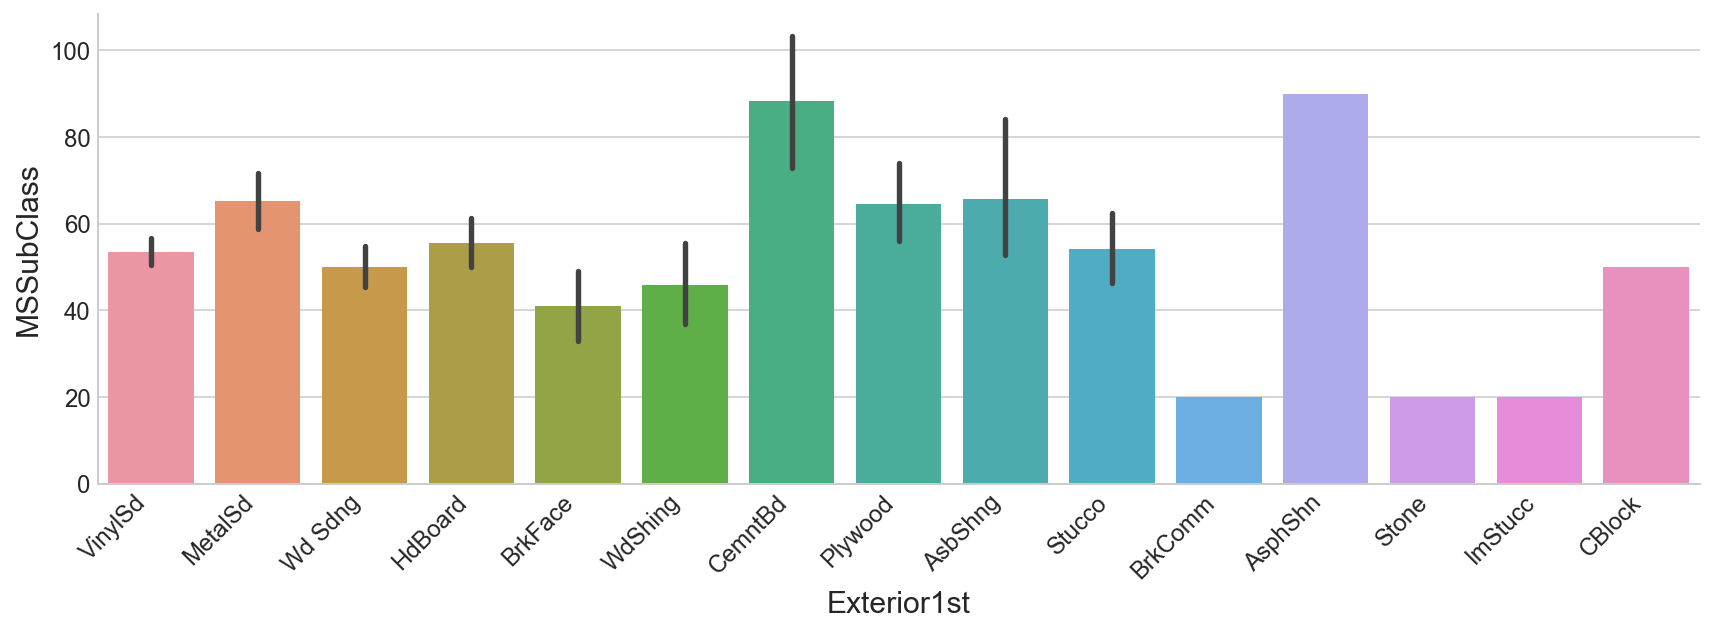

In [14]:
# Basic look if there is a connection between wall material and the subclass.
sns.factorplot(x='Exterior1st', y='MSSubClass', 
               data=house, kind='bar', aspect=3).set_xticklabels(rotation=45, horizontalalignment='right')

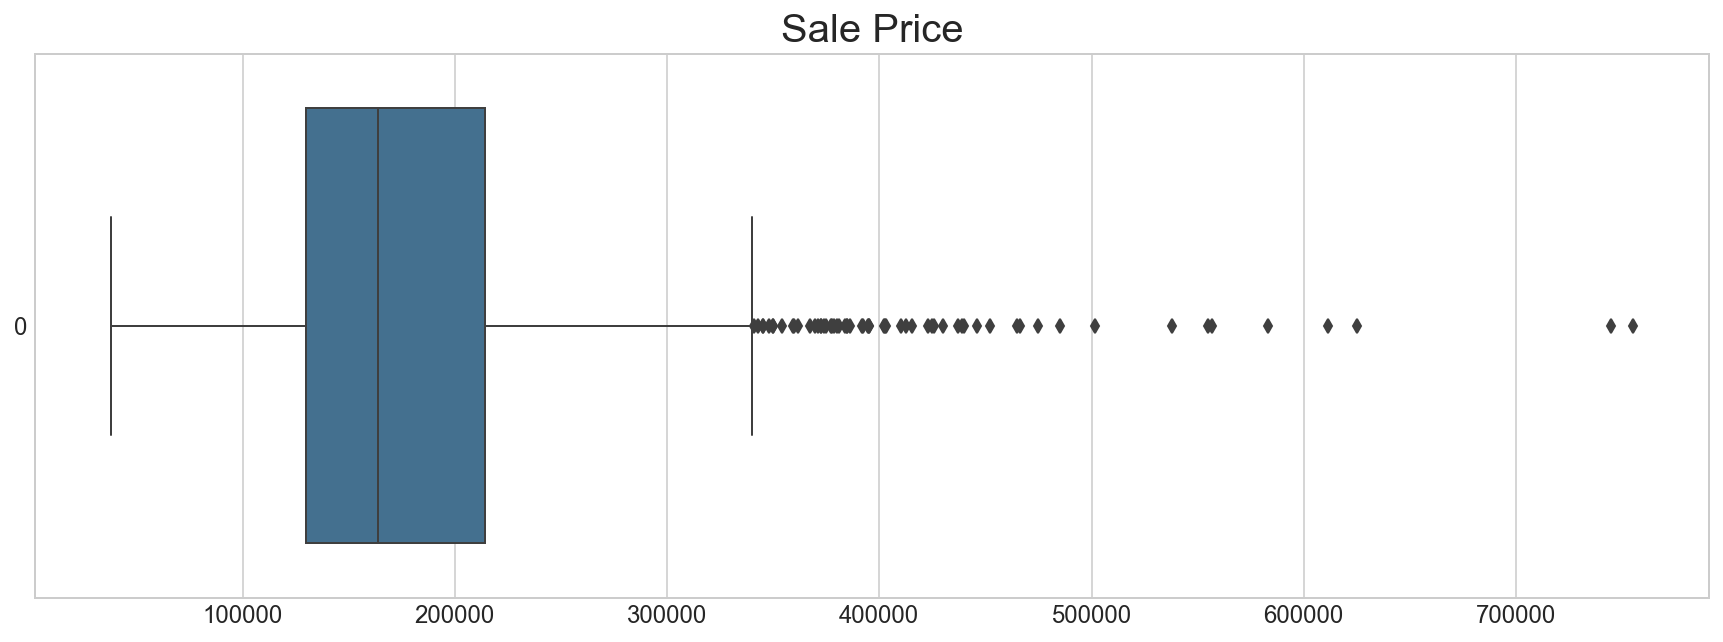

In [15]:
# Checking for outliers in Sale Price.
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
fig = plt.title('Sale Price')
ax = sns.boxplot(data=house['SalePrice'], orient='h',
                linewidth=1, saturation=0.5, ax=ax)

In [16]:
house[house['SalePrice'] > 600000] # Might cause issues.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000


C:\Users\ASUS-PC\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


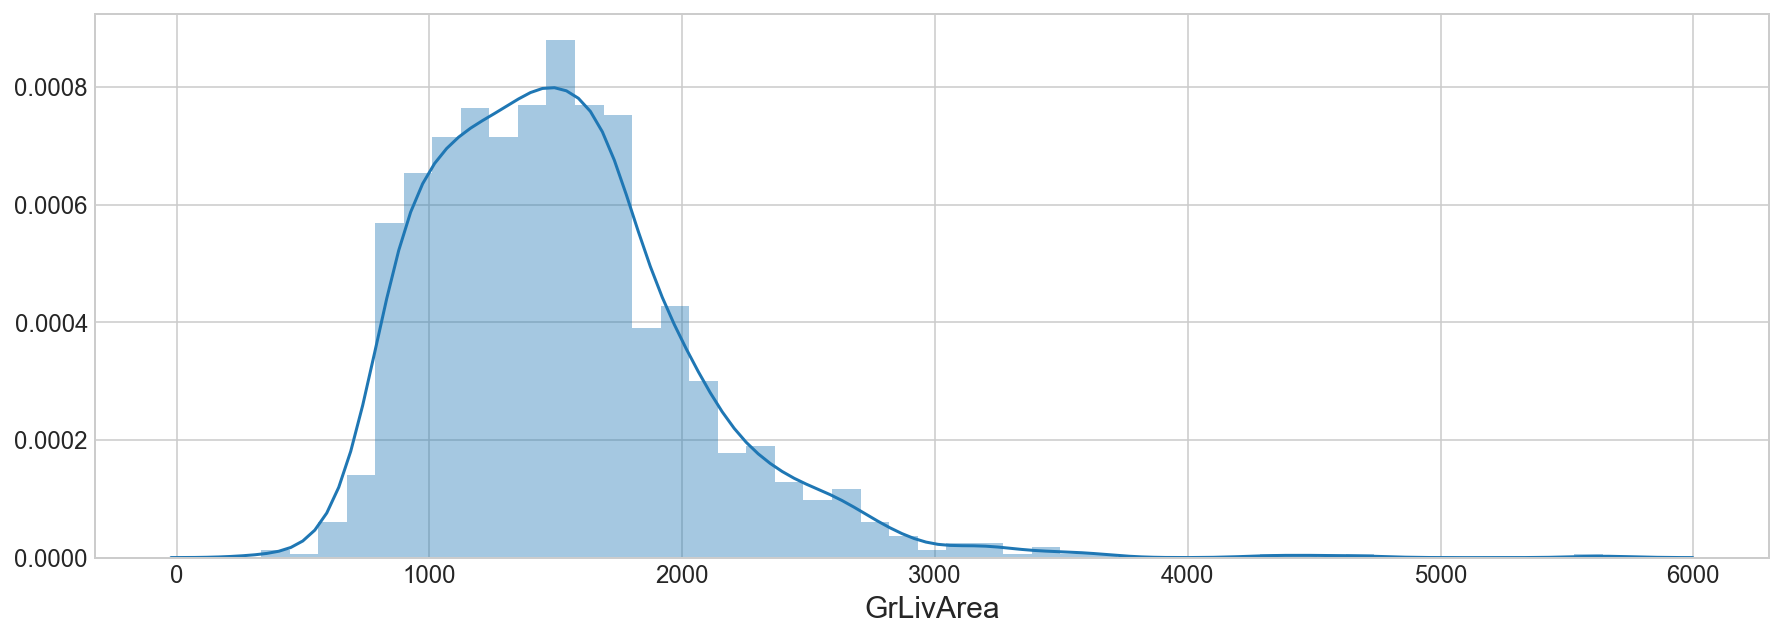

In [17]:
# Checking for outliers in living area.
plt.figure(figsize=(15, 5))
sns.distplot(house['GrLivArea'])
plt.show()

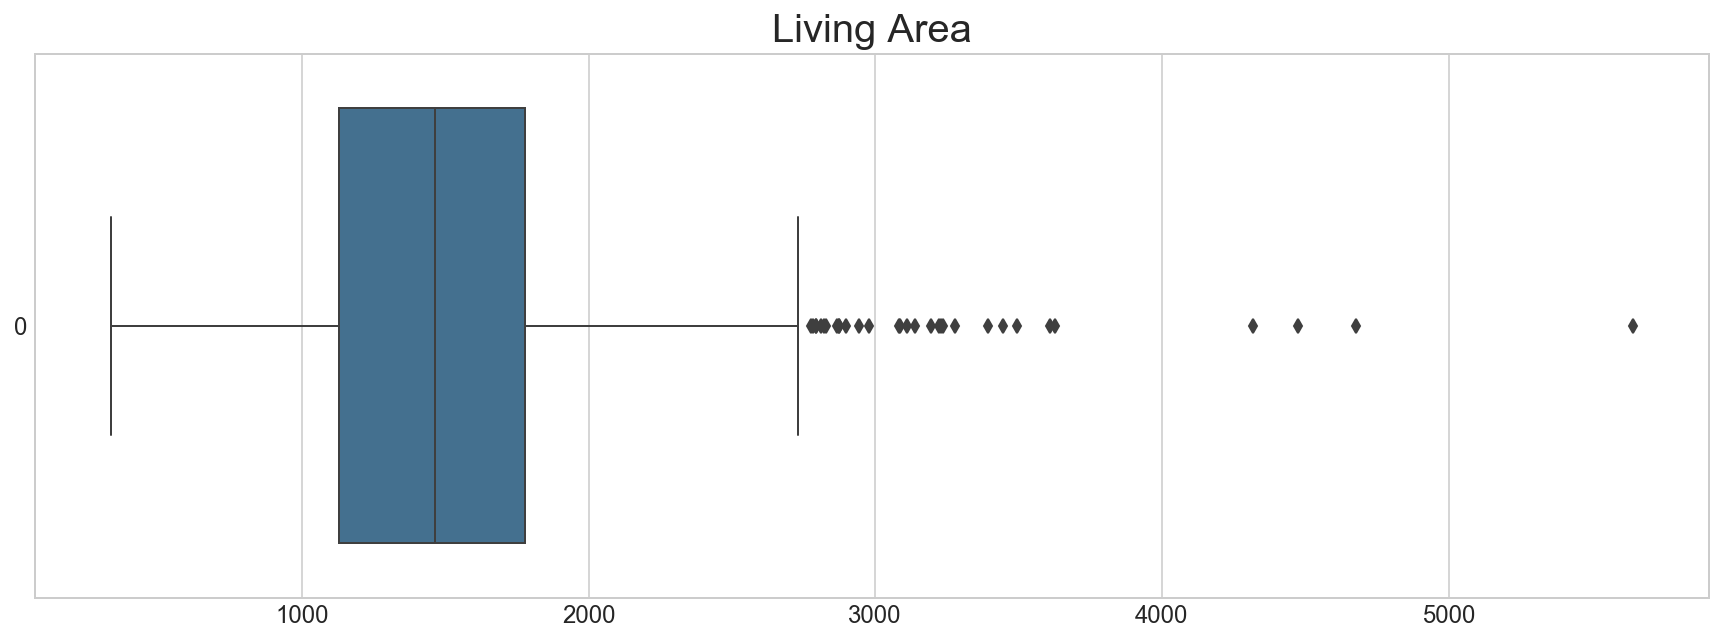

In [18]:
fig = plt.figure(figsize=(15, 5))
ax = fig.gca()
fig = plt.title('Living Area')
ax = sns.boxplot(data=house['GrLivArea'], orient='h',
                linewidth=1, saturation=0.5, ax=ax)

In [19]:
house[house['GrLivArea'] > 4500] # Interesting large size but cheap house.

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


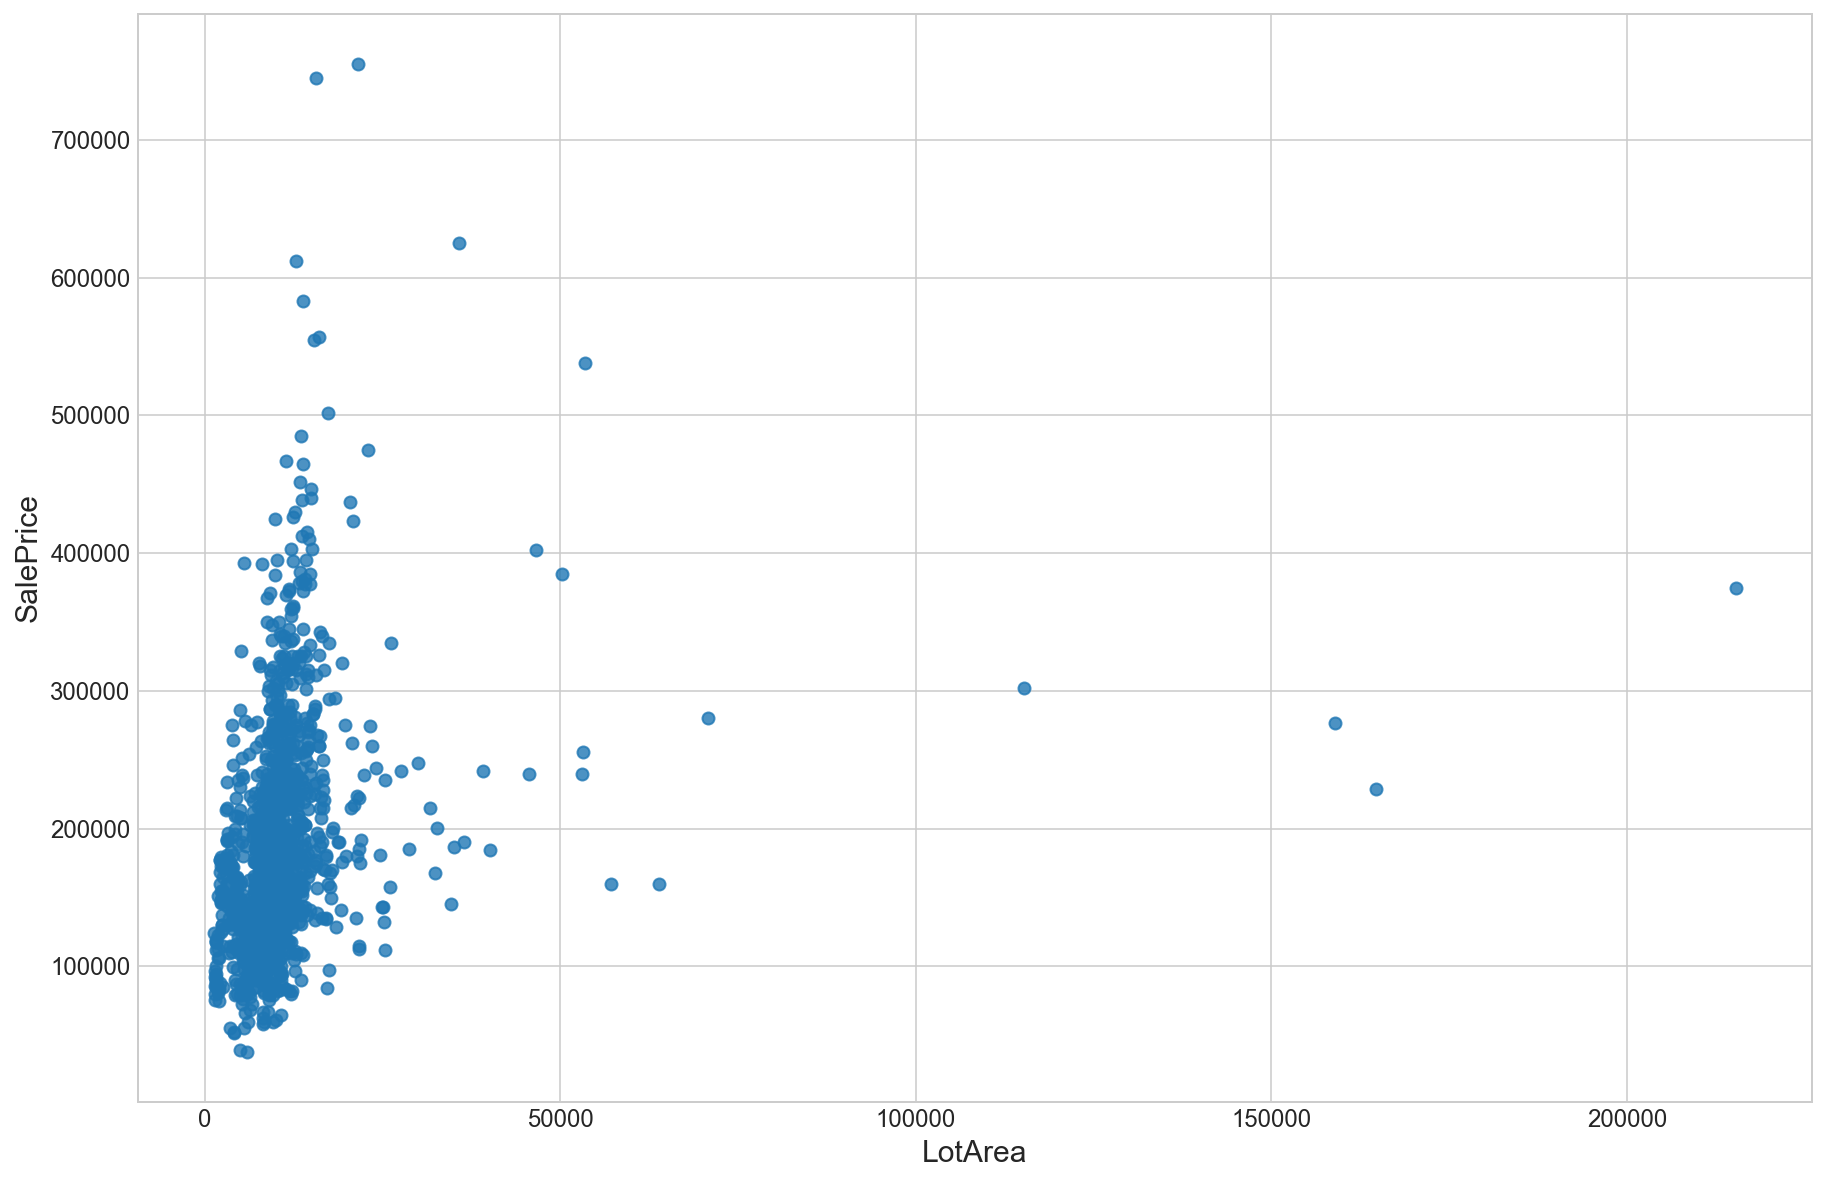

In [20]:
# Interesting to see lot area doesnt seem that correlated to sale price.
sns.regplot(x=house['LotArea'],y=house['SalePrice'],fit_reg=False)
plt.show()

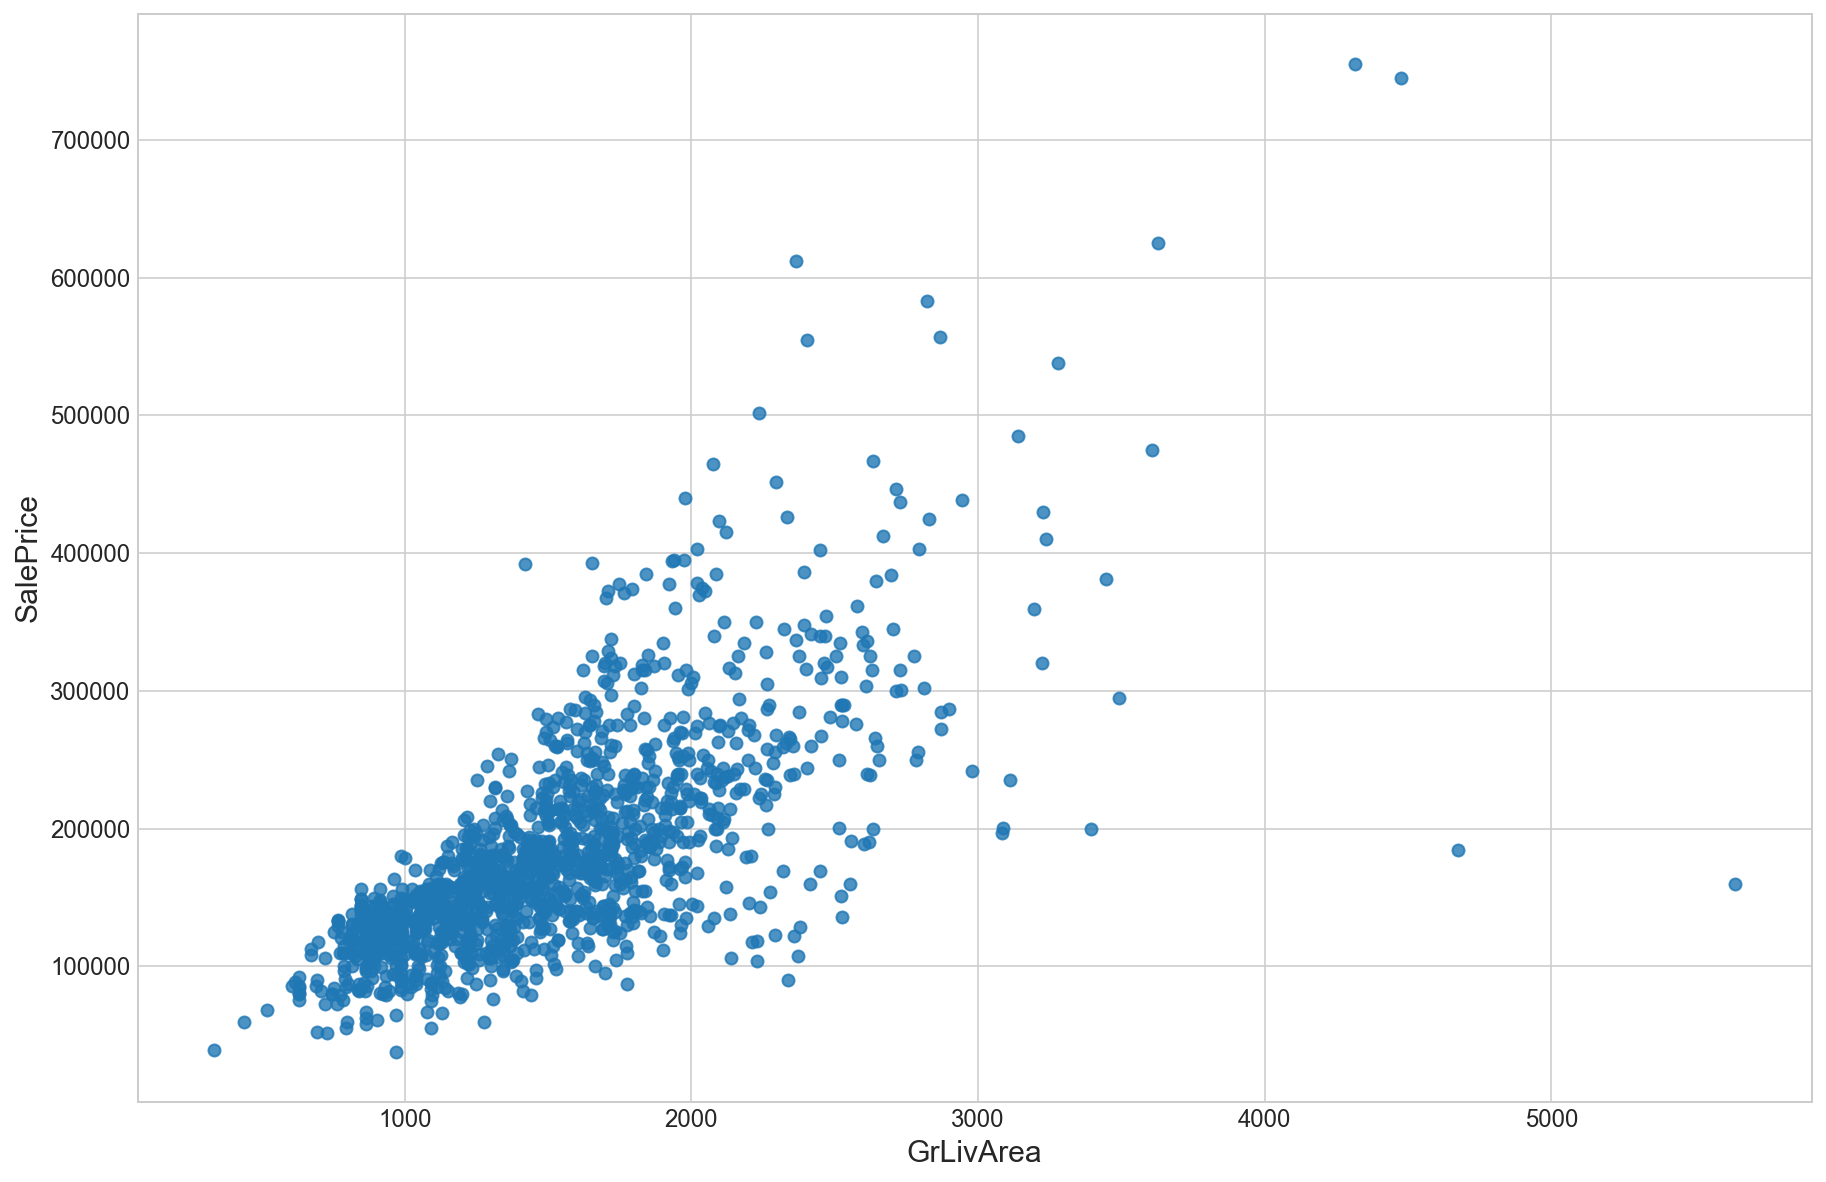

In [21]:
# Living area looks more correlated but there are some weird outliers that might mess up the model.
sns.regplot(x=house['GrLivArea'],y=house['SalePrice'],fit_reg=False)
plt.show()

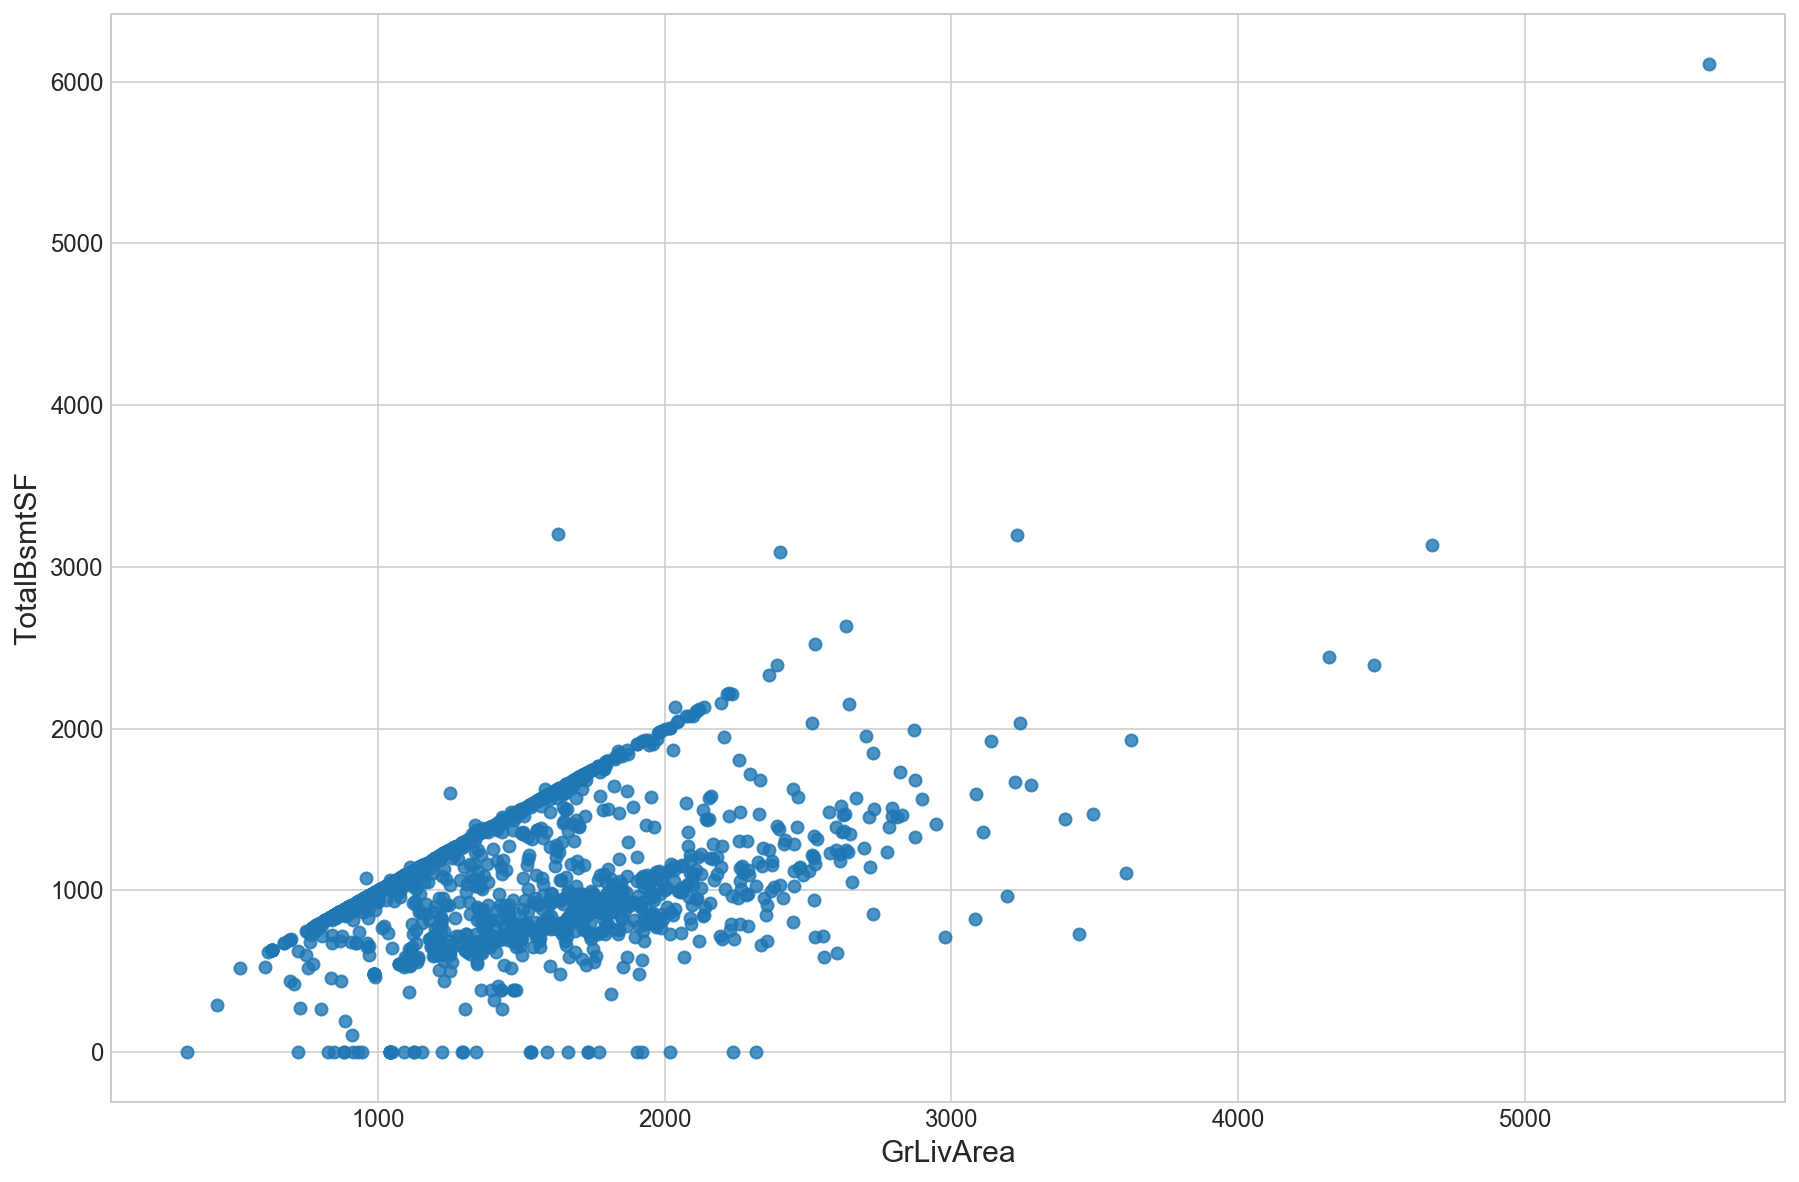

In [22]:
# Checking if there is any pattern between living area and basement size.
# Some interesting points with basement larger than the lviing area.
sns.regplot(x=house['GrLivArea'],y=house['TotalBsmtSF'],fit_reg=False)
plt.show()

In [23]:
# Checking if the outliers have anything else weird about them.
house[(house['SalePrice'] > 600000) | (house['GrLivArea'] > 4500)]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
691,692,60,RL,104.0,21535,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,1,2007,WD,Normal,755000
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,NaN,IR1,Lvl,AllPub,...,555,Ex,MnPrv,NaN,0,7,2007,WD,Abnorml,745000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


In [24]:
# Getting rid of those outliers
house = house[(house['SalePrice'] < 600000) & (house['GrLivArea'] < 4500)].copy()

In [25]:
# Basic cut for all fixed features.
fixed = ['MSZoning','MSSubClass','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope',
         'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt','YearRemodAdd','Exterior1st','Exterior2nd',
         'MasVnrType','MasVnrArea','Foundation','BsmtQual','BsmtExposure','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF', 'RoofStyle',
         '1stFlrSF','2ndFlrSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','TotRmsAbvGrd',
         'GarageType','GarageYrBlt','GarageCars','GarageArea','YrSold','SalePrice'
        ]
fixed_df = house[fixed]

In [26]:
fixed_df.info() 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Data columns (total 46 columns):
MSZoning        1443 non-null object
MSSubClass      1443 non-null int64
LotFrontage     1443 non-null float64
LotArea         1443 non-null int64
Street          1443 non-null object
Alley           89 non-null object
LotShape        1443 non-null object
LandContour     1443 non-null object
Utilities       1443 non-null object
LotConfig       1443 non-null object
LandSlope       1443 non-null object
Neighborhood    1443 non-null object
Condition1      1443 non-null object
Condition2      1443 non-null object
BldgType        1443 non-null object
HouseStyle      1443 non-null object
YearBuilt       1443 non-null int64
YearRemodAdd    1443 non-null int64
Exterior1st     1443 non-null object
Exterior2nd     1443 non-null object
MasVnrType      1443 non-null object
MasVnrArea      1443 non-null float64
Foundation      1443 non-null object
BsmtQual        1406 non-null object
BsmtExpos

In [27]:
# Indepth cut, only having one column for basement and garage as the others are either highly correlated or not relevant 
fixed_2 = ['MSSubClass','LotArea', 'Exterior1st', 'Exterior2nd','BsmtExposure','GarageType',
         'Neighborhood','Condition1','Condition2','BldgType','HouseStyle','YearBuilt',
         'TotalBsmtSF','BsmtFinSF1', 'RoofStyle', 'LotFrontage',
         'GrLivArea','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr', 
         'GarageArea','SalePrice','YrSold'
        ]

In [28]:
fixed_2_df = fixed_df[fixed_2].copy()

In [29]:
# Change class to string as it is a category
fixed_2_df['MSSubClass'] = fixed_2_df['MSSubClass'].astype(str)

In [30]:
# Change year to string as it is currently a number and the model wont know that it is a year
fixed_2_df['YearBuilt'] = fixed_2_df['YearBuilt'].astype(str)

In [31]:
# Select all columns of object type
fixed_obj_cols = list(fixed_2_df.select_dtypes(include='object').columns)

In [32]:
# Convert all the object columns to dummies and drop the first
dummies = pd.get_dummies(fixed_2_df[fixed_obj_cols], drop_first = True)

# Merge the dataframe result back onto the original dataframe
df = fixed_2_df.merge(dummies, left_index = True, right_index = True,how = 'outer')

In [33]:
# Drop the original columns which you got the dummies from
df = df.drop(fixed_obj_cols, axis = 1)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Columns: 230 entries, LotArea to RoofStyle_Shed
dtypes: float64(1), int64(11), uint8(218)
memory usage: 493.8 KB


In [35]:
# Split the data to pre 2010 data
X = df[df['YrSold'] < 2010].copy()
y = X['SalePrice'].values

In [36]:
 X.drop(columns=['SalePrice','YrSold'], inplace=True)

In [37]:
# Split test data to 2010 data
X_test = df[df['YrSold'] == 2010].copy()
y_test = X_test['SalePrice'].values

In [38]:
X_test.drop(columns=['SalePrice','YrSold'], inplace=True)

In [39]:
# Standarize the test and train data
ss = StandardScaler()
Xs = ss.fit_transform(X)
Xs_test = ss.fit_transform(X_test)

### Corr Map

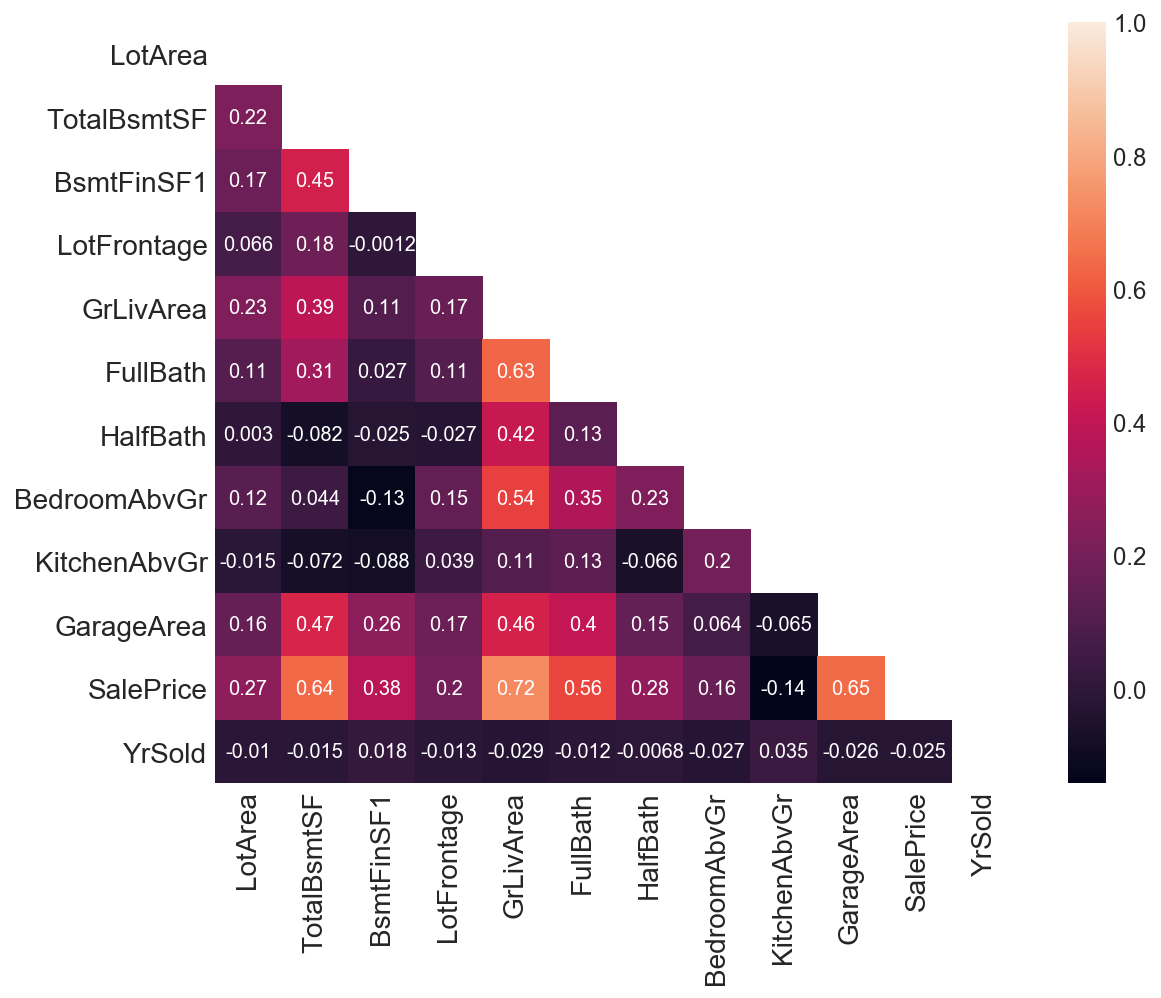

In [40]:
# Using easy correlation map to check for correlations
fixed_corr = fixed_2_df.corr()

fix, ax = plt.subplots(figsize=(9,7))

# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(fixed_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(fixed_corr, mask=mask, ax=ax, annot=True)

# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14)


plt.show()

### Models

#### First linreg

In [41]:
# Fit basic linear regression
linreg = LinearRegression()

linreg.fit(Xs,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [42]:
# Check train score
linreg.score(Xs,y)

0.9093123083444936

In [43]:
# Check on test data, very bad score
linreg.score(Xs_test,y_test)

-2.2413254973812175e+23

In [44]:
# Also checking it with cross-validation 
linreg_scores = cross_val_score(linreg, Xs, y, cv=10)
print(linreg_scores)
print(np.mean(linreg_scores))

[-1.11492047e+26  7.97773046e-01 -1.66312478e+23 -1.28921335e+25
 -6.14636667e+25 -1.38582694e+20 -1.61236867e+19 -1.84279390e+22
 -4.58772943e+25 -1.24573829e+24]
-2.3315577514152645e+25


In [45]:
linreg_scores_test = cross_val_score(linreg, Xs_test, y_test, cv=10)

print(linreg_scores_test)
print(np.mean(linreg_scores_test))

[-4.06460630e+26 -5.76943779e+22 -4.64323221e+26 -3.87946608e+27
 -1.57094243e+28 -6.25715980e+25 -6.38063522e+26 -6.73544010e+26
 -6.03827915e+25 -1.23290630e+27]
-2.3127200116881788e+27


#### Ridge

In [46]:
# Cross validation to get the optimal hyperparameters for ridge, fiting it on the optimal ridge and scoring on cross validation.
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print(ridge_scores)
print(np.mean(ridge_scores))

[0.90088739 0.80565809 0.89846416 0.85802916 0.85363919 0.86125883
 0.84727301 0.8596374  0.73920808 0.85635539]
0.8480410693711484


In [47]:
# Testing on the test data with cross validation
ridge_scores_test = cross_val_score(ridge, Xs_test, y_test, cv=10)

print(ridge_scores_test)
print(np.mean(ridge_scores_test))

[0.5966155  0.80887273 0.88296287 0.73893968 0.63658456 0.63940645
 0.72399596 0.85045166 0.57695368 0.70834303]
0.7163126116206111


In [48]:
ridge.fit(Xs,y)

Ridge(alpha=182.51834943190443, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [49]:
# Scoring without cross validation to get a standard score
ridge_r2 = ridge.score(Xs,y)
ridge_r2_test = ridge.score(Xs_test,y_test)

In [50]:
# Getting the residuals and calculating the root mean squared error
y_pred_ridge = ridge.predict(Xs)

RMSE_ridge = np.sqrt(mean_squared_error(y,y_pred_ridge))
print(RMSE_ridge)

23639.5539515917


In [51]:
# again for the test data
y_pred_ridge_test = ridge.predict(Xs_test)

RMSE_ridge_test = np.sqrt(mean_squared_error(y_test,y_pred_ridge_test))
print(RMSE_ridge_test)

25333.409439961244


#### Lasso

In [52]:
# Cross validation to get the optimal hyperparameters for lasso, fiting it on the optimal lasso and scoring on cross validation.

optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print(lasso_scores)
print(np.mean(lasso_scores))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

[0.89608686 0.84693201 0.90036334 0.87192429 0.85469733 0.87075501
 0.84320191 0.83502056 0.76065032 0.86618977]
0.8545821391193587


In [53]:
# Testing on the test data with cross validation
lasso_scores_test = cross_val_score(lasso, Xs_test, y_test, cv=10)

print(lasso_scores_test)
print(np.mean(lasso_scores_test))

[0.54527238 0.72433772 0.95823741 0.68720613 0.59209695 0.72271629
 0.76763003 0.89897064 0.63286348 0.70795925]
0.7237290279943557


In [54]:
lasso.fit(Xs, y)

Lasso(alpha=880.188497764406, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [55]:
# Scoring without cross validation to get a standard score

lasso_r2 = lasso.score(Xs,y)
lasso_r2_test = lasso.score(Xs_test,y_test)

In [56]:
# Getting the residuals and calculating the root mean squared error

y_pred_lasso = lasso.predict(Xs)

RMSE_lasso = np.sqrt(mean_squared_error(y,y_pred_lasso))
print(RMSE_lasso)

24824.54860319518


In [57]:
# Again for the test data
y_pred_lasso_test = lasso.predict(Xs_test)

RMSE_lasso_test = np.sqrt(mean_squared_error(y_test,y_pred_lasso_test))
print(RMSE_lasso_test)

25159.322266597745


#### Enet

In [58]:
# Cross validation to get the optimal hyperparameters for enet, fiting it on the optimal enet and scoring on cross validation.

l1_ratios = np.linspace(0.05, 1, 25)

optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
optimal_enet.fit(Xs, y)

print(optimal_enet.alpha_)
print(optimal_enet.l1_ratio_)

enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

enet_scores = cross_val_score(enet, Xs, y, cv=10)

print(enet_scores)
print(np.mean(enet_scores))

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

...............[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:   13.3s finished


875.5239754302
1.0
[0.89618355 0.84681282 0.90040116 0.87188369 0.85476066 0.87075567
 0.84329047 0.83514683 0.76040554 0.86616972]
0.8545810123446008


In [59]:
# Testing on the test data with cross validation

enet_scores_test = cross_val_score(enet, Xs_test, y_test, cv=10)

print(enet_scores_test)
print(np.mean(enet_scores_test))

[0.54527901 0.72409296 0.95825696 0.68643867 0.59191851 0.72278151
 0.76758421 0.89889979 0.63259073 0.70787964]
0.7235721990584063


In [60]:
enet.fit(Xs,y)

ElasticNet(alpha=875.5239754302, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [61]:
# Scoring without cross validation to get a standard score

enet_r2 = enet.score(Xs,y)
enet_r2_test = enet.score(Xs_test,y_test)

In [62]:
# Getting the residuals and calculating the root mean squared error

y_pred_enet = enet.predict(Xs)

RMSE_enet = np.sqrt(mean_squared_error(y,y_pred_enet))
print(RMSE_enet)

24813.05603487071


In [63]:
# Again for the test data
y_pred_enet_test = enet.predict(Xs_test)

RMSE_enet_test = np.sqrt(mean_squared_error(y_test,y_pred_enet_test))
print(RMSE_enet_test)

25159.469649731553


#### Regularization coefs

In [64]:
# Create dataframes of each of the regularizations and sort by absolute values 
ridge_coefs_df = pd.DataFrame({'variable':X.columns,
                            'coef':ridge.coef_,
                            'abs_coef':np.abs(ridge.coef_)})
lasso_coefs_df = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})
enet_coefs_df = pd.DataFrame({'variable':X.columns,
                            'coef':enet.coef_,
                            'abs_coef':np.abs(enet.coef_)})

ridge_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)
lasso_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)
enet_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)

In [65]:
# As enet was top scoring, create dataframe without absolute coefficients so its easier to plot later
enet_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':enet.coef_}, index=X.columns)

In [66]:
# Getting only the enet coefs that have an impact on the model (not zero)
enet_cols = enet_coefs[enet_coefs['coef'] != 0]

In [67]:
enet_cols.shape

(93, 2)

In [68]:
enet_coefs_df.head(20)

,abs_coef,coef,variable
4,31626.964647,31626.964647,GrLivArea
1,11115.494408,11115.494408,TotalBsmtSF
78,10449.302996,10449.302996,Neighborhood_NridgHt
2,8607.323815,8607.323815,BsmtFinSF1
9,7631.703670,7631.703670,GarageArea
221,7416.010464,7416.010464,YearBuilt_2008
84,6637.542995,6637.542995,Neighborhood_StoneBr
8,5798.890256,-5798.890256,KitchenAbvGr
53,4766.108698,4766.108698,BsmtExposure_Gd
77,4601.457054,4601.457054,Neighborhood_NoRidge


#### RFECV

In [69]:
# cross validation on recursive feature selection to get the top performing columns and put the top columns in a list 
selector = RFECV(linreg, step=1, cv=10)
selector = selector.fit(Xs, y)

# print(selector.support_)
print(selector.ranking_)

features = [f for f,s in zip(X.columns, selector.support_) if s]

[ 25   2   8 219   1 188  57  21  18   3  58 216 183  40 185 212 213 166
   5 182 186  35  61  11  24  54  29  13  37  73 228  66 222 202 179  50
  36 227 215 225 177  16  30  74 220  65 199 200 197 201  20  41  85   6
 217  46 203  31  59  28 141  34  39 189  72 205 194 116  22  96 115 191
  45  99 178  63 206  23   4 175 192 207 208   9   7 190  32 223  43  88
  84  62  87 221  86 218 176  15 211  14 204 119 184  10 180 214  56 139
 209 169 167 196 195  38 153 124 171 210  33  12 226 168 131 102 170  71
 135 193 173 174 145 104 110 224 125 152 109 114 158  79 136 106 130 172
 143  70 111 129  81  93  78  95 123 134  82  80 117 128 127 156 126 107
 105 108 181 146 164 132 155 144 162 142 151 154 148 133 160 161 163  94
 149 147 157 121 150 112 165 100 140 120 122 137  90  91 101 113  98 159
 138 118  92  97  60  89 103  83  77  75  48  76  69  68  55  67  51  53
  49  52  42  27  26  19  44 198  64  47 187  17]


In [70]:
features

['GrLivArea']

In [71]:
# Scoring the top features
RFECV_r2 = selector.score(Xs,y)
RFECV_r2_test = selector.score(Xs_test,y_test)

In [72]:
# Create a new X with only the top features from RFECV and standardize it
Xs_RFECV = ss.fit_transform(X[features])

In [73]:
# Cross validate the new X
RFECV_scores = cross_val_score(linreg, Xs_RFECV, y, cv=10)
print(RFECV_scores)
print(np.mean(RFECV_scores))

[0.59517661 0.56572093 0.59251903 0.60199647 0.45728615 0.55711588
 0.4096782  0.45354849 0.29121389 0.42004108]
0.49442967184851233


In [74]:
# Getting the residuals and calculating the root mean squared error

y_pred_RFECV = selector.predict(Xs)

RMSE_RFECV = np.sqrt(mean_squared_error(y,y_pred_RFECV))
print(RMSE_RFECV)

52218.205789513326


In [75]:
# Again for test data
y_pred_RFECV_test = selector.predict(Xs_test)

RMSE_RFECV_test = np.sqrt(mean_squared_error(y_test,y_pred_RFECV_test))
print(RMSE_RFECV_test)

48355.45196014332


#### Kbest

In [76]:
# Get names of columns 
cols = list(X.columns)

In [77]:
# Normalize as chi2 doesnt work with negative values
Xn= normalize(X)

In [78]:
skb_chi2 = SelectKBest(chi2, k=5)

# train the selector on our data
skb_chi2.fit(Xn, y)

# examine results
kbest = pd.DataFrame([cols, list(skb_chi2.scores_)], 
                     index=['feature','chi2 score']).T.sort_values('chi2 score', ascending=False)
kbest.head(10)

,feature,chi2 score
2,BsmtFinSF1,37.0599
4,GrLivArea,24.059
1,TotalBsmtSF,19.9039
9,GarageArea,10.9431
3,LotFrontage,1.33517
0,LotArea,0.892908
64,Neighborhood_BrDale,0.297775
129,YearBuilt_1913,0.289898
11,MSSubClass_180,0.270402
72,Neighborhood_MeadowV,0.265801


In [79]:
# Getting top 8
kbest_cut = kbest[0:8]

In [80]:
# Getting just the column names
kbest_cols = list(kbest_cut['feature'])

In [81]:
# Standardize the new X
Xs_chi2 = ss.fit_transform(X[kbest_cols])

In [82]:
# Same for new test
Xs_test_chi2 = ss.fit_transform(X_test[kbest_cols])

In [83]:
# Cross validate and check scores
chi2_scores = cross_val_score(linreg, Xs_RFECV, y, cv=10)
print(chi2_scores)
print(np.mean(chi2_scores))

[0.59517661 0.56572093 0.59251903 0.60199647 0.45728615 0.55711588
 0.4096782  0.45354849 0.29121389 0.42004108]
0.49442967184851233


In [84]:
linreg.fit(Xs_chi2,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [85]:
# Get the standard scores
chi2_r2 = linreg.score(Xs_chi2,y)
chi2_r2_test = linreg.score(Xs_test_chi2,y_test)

In [86]:
# Get the residuals and get the root mean squared error
y_pred_chi2 = linreg.predict(Xs_chi2)

RMSE_chi2 = np.sqrt(mean_squared_error(y,y_pred_chi2))
print(RMSE_chi2)

38338.44299063389


In [87]:
# Again for test data
y_pred_chi2_test = linreg.predict(Xs_test_chi2)

RMSE_chi2_test = np.sqrt(mean_squared_error(y_test,y_pred_chi2_test))
print(RMSE_chi2_test)

34443.14046652704


#### SGD

In [490]:
# Initialize stochastic gradient descent and grid search for best hyperparameters 
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()
sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False, n_jobs=-1)

sgd_reg_gs.fit(Xs, y)

GridSearchCV(cv=5, error_score='raise',
       estimator=SGDRegressor(alpha=0.0001, average=False, epsilon=0.1, eta0=0.01,
       fit_intercept=True, l1_ratio=0.15, learning_rate='invscaling',
       loss='squared_loss', max_iter=None, n_iter=None, penalty='l2',
       power_t=0.25, random_state=None, shuffle=True, tol=None, verbose=0,
       warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'loss': ['squared_loss', 'huber'], 'penalty': ['l1', 'l2'], 'alpha': array([1.00000e-05, 1.77828e-05, 3.16228e-05, 5.62341e-05, 1.00000e-04,
       1.77828e-04, 3.16228e-04, 5.62341e-04, 1.00000e-03, 1.77828e-03,
       3.16228e-03, 5.62341e-03, 1.00000e-02, 1.77828e-02, 3.16228e-02,
       5.62341e-02, 1.00000e-01, 1.77828e-01, 3.16228e-01, 5.62341e-01,
       1.00000e+00, 1.77828e+00, 3.16228e+00, 5.62341e+00, 1.00000e+01])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=False)

In [491]:
# See what the best parameters are
print(sgd_reg_gs.best_params_)
print(sgd_reg_gs.best_score_)
best_sgd = sgd_reg_gs.best_estimator_

{'alpha': 1.0, 'loss': 'squared_loss', 'penalty': 'l2'}
0.8113793875318712


In [492]:
# cross validate and score the sgd
sgd_scores = cross_val_score(best_sgd, Xs, y, cv=10)
print(sgd_scores)
print(np.mean(sgd_scores))

[0.85950251 0.76005884 0.84646272 0.8240103  0.78689963 0.80046358
 0.81181005 0.84627403 0.77237952 0.82404074]
0.81319019277839


In [493]:
# Again for test data
sgd_scores_test = cross_val_score(best_sgd, Xs_test, y_test, cv=10)
print(sgd_scores_test)
print(np.mean(sgd_scores_test))

[-0.77810486  0.09634908  0.42841637 -0.11934122 -0.94403179  0.40860635
  0.12996279  0.29195145 -0.22096013  0.40765712]
-0.029949484333125814


In [494]:
# Get a standard score
sgd_r2_test = best_sgd.score(Xs_test, y_test)
sgd_r2 = best_sgd.score(Xs, y)

In [495]:
best_sgd.score(Xs, y)

0.8417376633537402

In [496]:
# Get residuals and calculate root mean squared error
y_pred_sgd = best_sgd.predict(Xs)

RMSE_sgd = np.sqrt(mean_squared_error(y,y_pred_sgd))

In [497]:
# Again for test data
y_pred_sgd_test = best_sgd.predict(Xs_test)

RMSE_sgd_test = np.sqrt(mean_squared_error(y_test,y_pred_sgd_test))

### Scores

In [498]:
# Create simple function to get the mean and standard deviation for each models cross validation scores
def score(X):
    return X.mean(), X.std()

In [499]:
# Scoring train data CV
all_scores = [score(enet_scores),score(lasso_scores),
             score(ridge_scores),score(sgd_scores),
             score(RFECV_scores),score(chi2_scores)]

pd.DataFrame(all_scores, columns=['mean score', 'std score'], index = ['enet', 'lasso', 'ridge', 'sgd','RFECV','chi2'])

,mean score,std score
enet,0.854581,0.037363
lasso,0.854582,0.037295
ridge,0.848041,0.044143
sgd,0.813190,0.031504
RFECV,0.494430,0.098701
chi2,0.494430,0.098701


In [500]:
# Scoring test data CV
all_scores_test = [score(enet_scores_test),score(lasso_scores_test),
             score(ridge_scores_test),score(sgd_scores_test)]

pd.DataFrame(all_scores_test, columns=['mean score', 'std score'], index = ['enet', 'lasso', 'ridge','sgd'])

,mean score,std score
enet,0.723572,0.121152
lasso,0.723729,0.121097
ridge,0.716313,0.100492
sgd,-0.029949,0.466780


In [501]:
# RMSE Scoring train data
RMSE_scores = [RMSE_enet,RMSE_lasso, RMSE_ridge, RMSE_sgd,
               RMSE_RFECV,RMSE_chi2]

pd.DataFrame(RMSE_scores, columns=['RMSE'], index = ['enet', 'lasso', 'ridge', 'sgd','RFECV','chi2']).round()

,RMSE
enet,24813.0
lasso,24825.0
ridge,23640.0
sgd,29804.0
RFECV,52218.0
chi2,38338.0


In [502]:
# RMSE Scoring test data
RMSE_scores_test = [RMSE_enet_test,RMSE_lasso_test, RMSE_ridge_test,
                   RMSE_sgd_test, RMSE_RFECV_test, RMSE_chi2_test]

pd.DataFrame(RMSE_scores_test, columns=['RMSE'], index = ['enet', 'lasso', 'ridge','sgd' ,'RFECV','chi2']).round()

,RMSE
enet,25159.0
lasso,25159.0
ridge,25333.0
sgd,28133.0
RFECV,48355.0
chi2,34443.0


In [503]:
# R2 scores for normal fit
r2_scores = [enet_r2,lasso_r2,ridge_r2,
             sgd_r2,RFECV_r2,chi2_r2]

pd.DataFrame(r2_scores, columns=['R^2'], index = ['enet', 'lasso', 'ridge', 'sgd','RFECV','chi2'])

,R^2
enet,0.890305
lasso,0.890203
ridge,0.900435
sgd,0.841738
RFECV,0.514186
chi2,0.738124


In [504]:
# R2 scores for test data
r2_scores_test = [enet_r2_test,lasso_r2_test,ridge_r2_test,
                  sgd_r2_test,RFECV_r2_test,chi2_r2_test]
pd.DataFrame(r2_scores_test, columns=['R^2'], index = ['enet', 'lasso', 'ridge', 'sgd','RFECV','chi2'])

,R^2
enet,0.874525
lasso,0.874526
ridge,0.872784
sgd,0.843115
RFECV,0.536504
chi2,0.764842


In [505]:
# Printing out best performing model, enet
# Could make it so that it prints out whichever model performs top, if another model performs better with new data
print('R^2 enet:',enet_r2)
print('R^2 enet test:',enet_r2_test)
print('RMSE enet:',RMSE_enet)
print('RMSE enet test:',RMSE_enet_test)

R^2 enet: 0.8903049882046785
R^2 enet test: 0.8745247515329992
RMSE enet: 24813.05603487071
RMSE enet test: 25159.469649731553


In [506]:
# Assign residuals for best performing model
residuals = y - y_pred_enet
residuals_test =  y_test - y_pred_enet_test

### Part 1 Answers

__Performance__ <br>
> The model performs quite well with a 89% accuracy on pre 2010 data and once tested on the 2010 data it has an accuracy of 87%.

> The best estimator of price is the Living Area variable showing that each standardized unit increase of living area, gives an increase of \$31,626.

> The highest price decreaser is number of Kitchens. It decreases the price by \$5,798 when the number of kitchens goes up.

In [507]:
enet_coefs_df.head(10)

,abs_coef,coef,variable
4,31626.964647,31626.964647,GrLivArea
1,11115.494408,11115.494408,TotalBsmtSF
78,10449.302996,10449.302996,Neighborhood_NridgHt
2,8607.323815,8607.323815,BsmtFinSF1
9,7631.703670,7631.703670,GarageArea
221,7416.010464,7416.010464,YearBuilt_2008
84,6637.542995,6637.542995,Neighborhood_StoneBr
8,5798.890256,-5798.890256,KitchenAbvGr
53,4766.108698,4766.108698,BsmtExposure_Gd
77,4601.457054,4601.457054,Neighborhood_NoRidge


### Plots

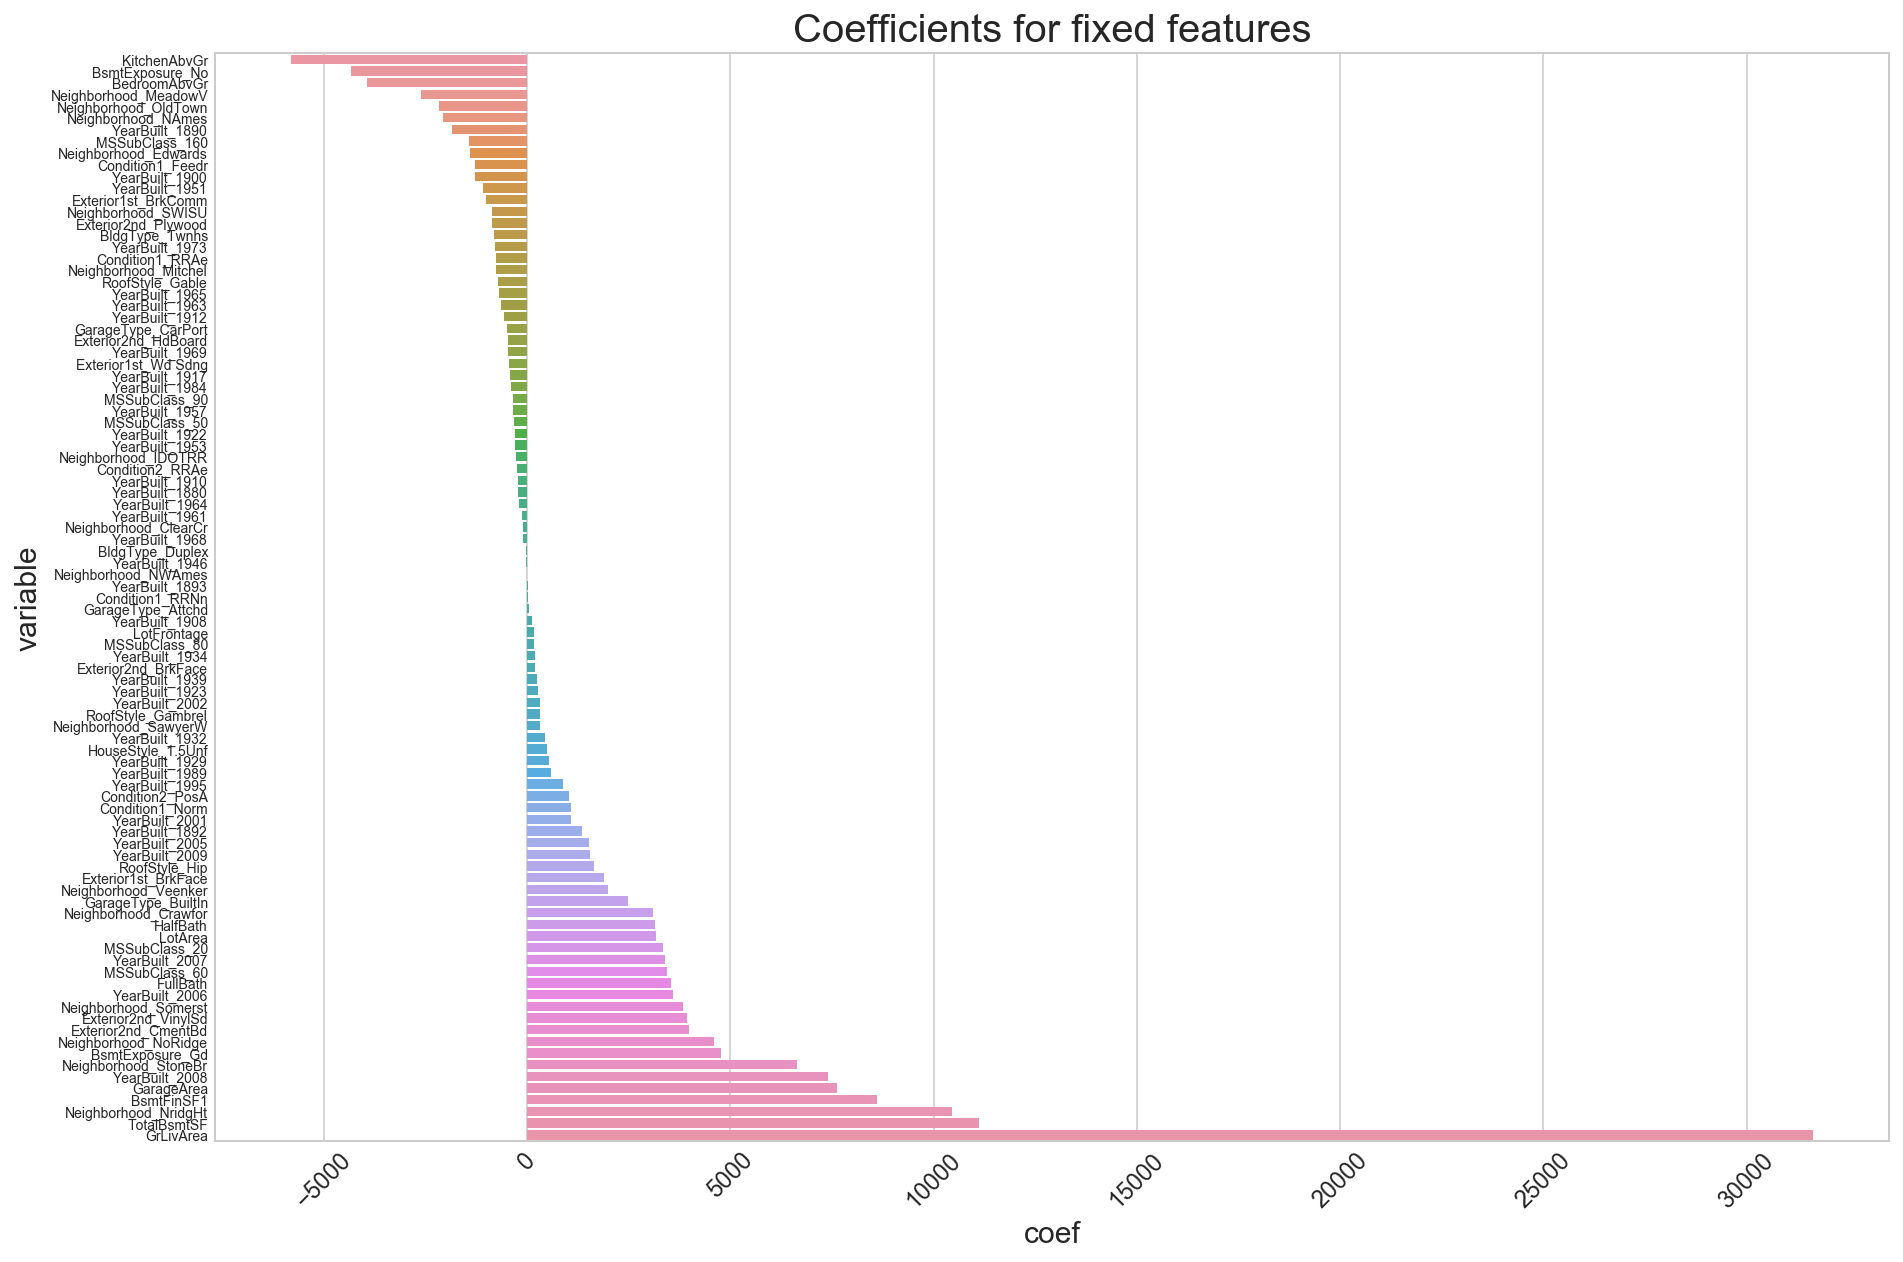

In [508]:
# Visual coefficients for fixed features on best performing model, enet
plt.figure(figsize=(15,10))
sns.barplot(x='coef',y='variable',data=enet_cols.sort_values('coef'))
plt.xticks(rotation=45)
plt.yticks(fontsize=7)
plt.title('Coefficients for fixed features')

plt.show()

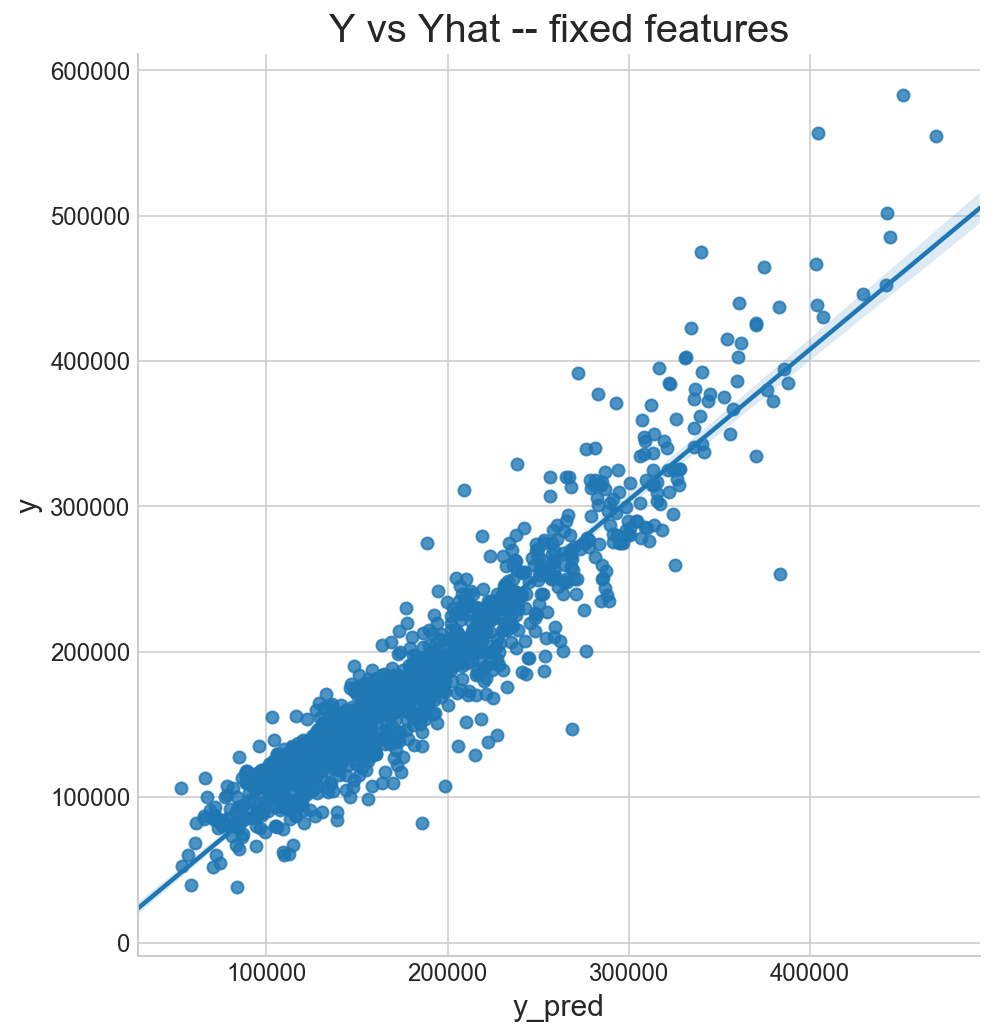

In [509]:
# visual check for how well the model is performing
pred_df = pd.DataFrame(list(zip(y,y_pred_enet)), columns=['y', 'y_pred'])

sns.lmplot(x="y_pred", y="y", data=pred_df, size=7)
plt.title('Y vs Yhat -- fixed features')
plt.show()

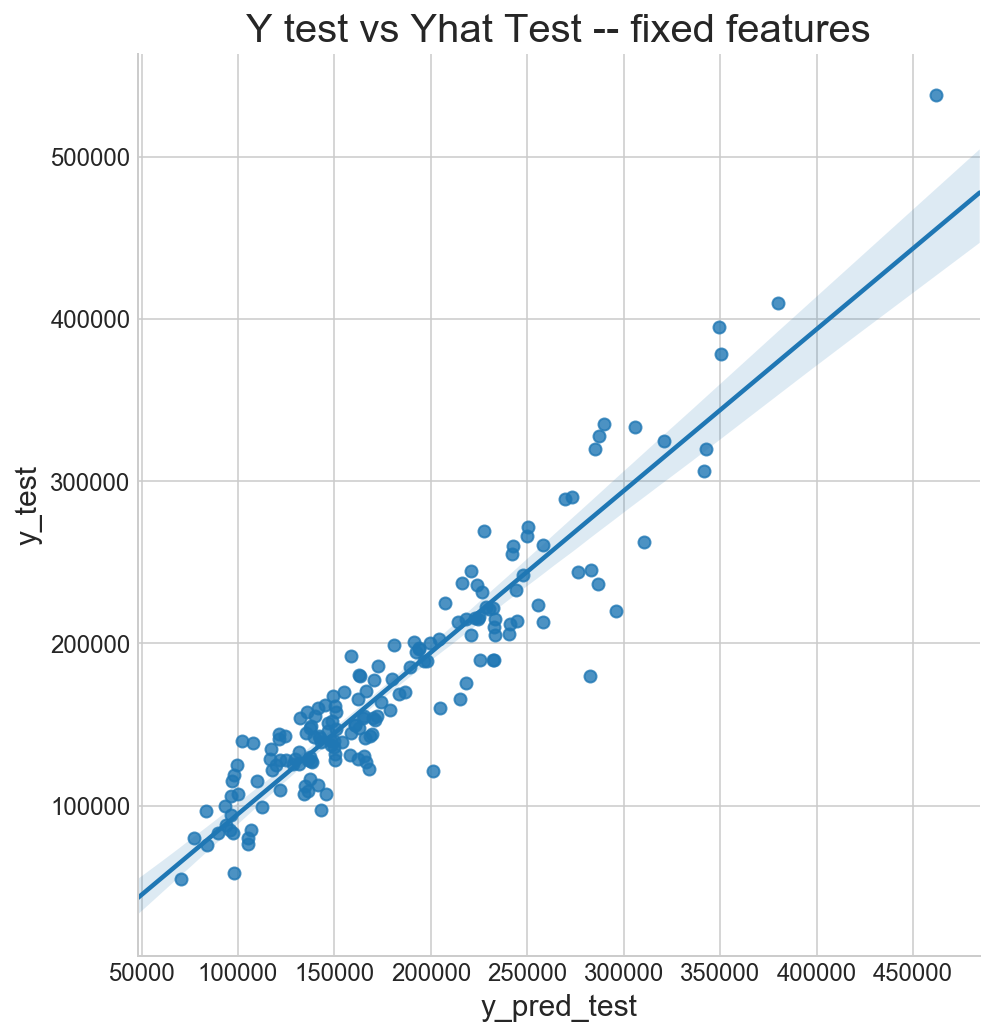

In [510]:
# Again but on test data
pred_test_df = pd.DataFrame(list(zip(y_test,y_pred_enet_test)), columns=['y_test', 'y_pred_test'])

sns.lmplot(x="y_pred_test", y="y_test", data=pred_test_df, size=7)
plt.title('Y test vs Yhat Test -- fixed features')
plt.show()

C:\Users\ASUS-PC\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


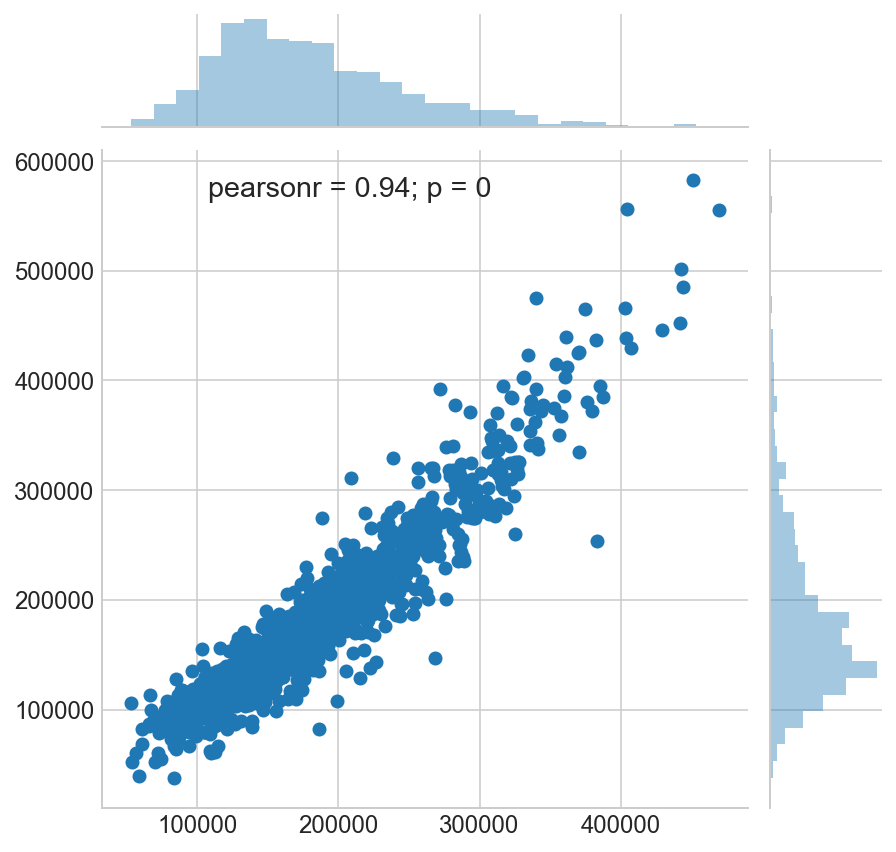

In [511]:
sns.jointplot(y_pred_enet,y)
plt.show()

C:\Users\ASUS-PC\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


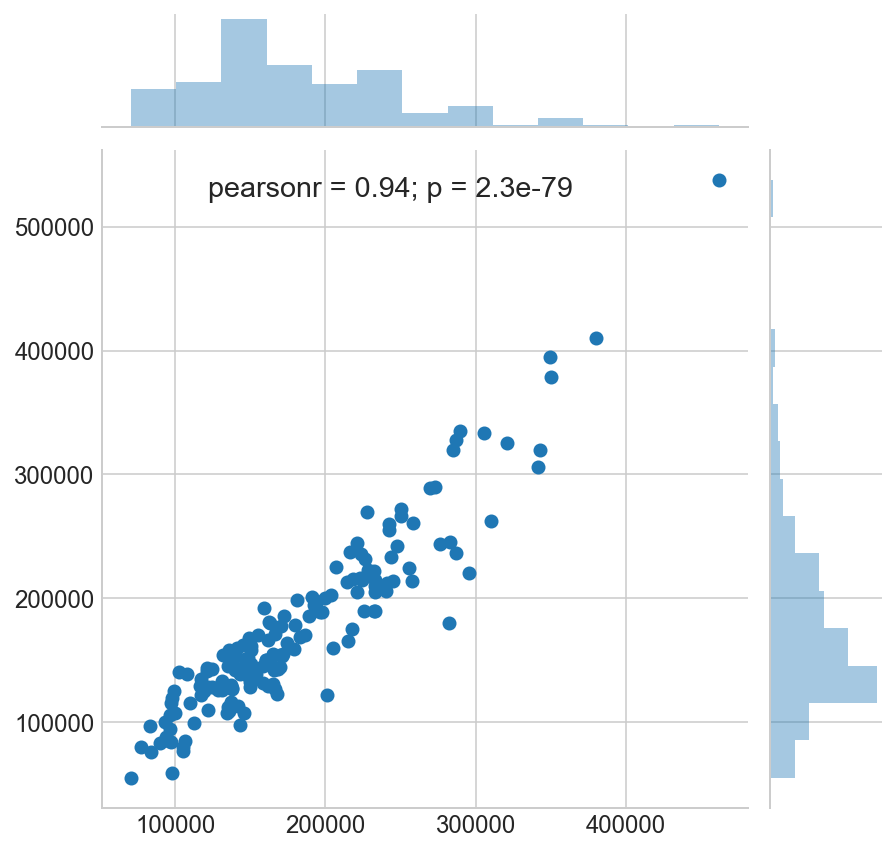

In [512]:
sns.jointplot(y_pred_enet_test, y_test)
plt.show()

## Part 2

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

### EDA

In [513]:
# A:
house['ExterCond'].value_counts()

# Checking which columns I need to alter
# $$ == Dummy
# $ == change to numeric
# OverallQual
# OverallCond
# RoofMatl $$
# ExterQual $
# ExterCond $
# BsmtCond $
# BsmtFinType1 $$
# BsmtFinType2 $$
# Heating $$
# HeatingQC $
# CentralAir N to 0
# Electrical $$
# LowQualFinSF
# KitchenQual $
# Functional $$
# Fireplaces 
# FireplaceQu $
# GarageFinish $$
# GarageQual $
# GarageCond $


TA    1269
Gd     144
Fa      26
Ex       3
Po       1
Name: ExterCond, dtype: int64

In [514]:
house.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Data columns (total 81 columns):
Id               1443 non-null int64
MSSubClass       1443 non-null int64
MSZoning         1443 non-null object
LotFrontage      1443 non-null float64
LotArea          1443 non-null int64
Street           1443 non-null object
Alley            89 non-null object
LotShape         1443 non-null object
LandContour      1443 non-null object
Utilities        1443 non-null object
LotConfig        1443 non-null object
LandSlope        1443 non-null object
Neighborhood     1443 non-null object
Condition1       1443 non-null object
Condition2       1443 non-null object
BldgType         1443 non-null object
HouseStyle       1443 non-null object
OverallQual      1443 non-null int64
OverallCond      1443 non-null int64
YearBuilt        1443 non-null int64
YearRemodAdd     1443 non-null int64
RoofStyle        1443 non-null object
RoofMatl         1443 non-null object
Exterior1st      1443 non-n

In [515]:
ren_cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1", "BsmtFinType2",
            "Heating", "HeatingQC", "CentralAir", "Electrical", "LowQualFinSF", "KitchenQual", "Functional",
            "FireplaceQu", "GarageFinish", "GarageQual", "GarageCond", "SalePrice","YrSold",'MasVnrType','MasVnrArea','RoofMatl','PoolArea']

In [516]:
ren_df = house[ren_cols].copy()

In [517]:
ren_df.head()

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtCond,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,...,FireplaceQu,GarageFinish,GarageQual,GarageCond,SalePrice,YrSold,MasVnrType,MasVnrArea,RoofMatl,PoolArea
0,7,5,Gd,TA,TA,GLQ,Unf,GasA,Ex,Y,...,NaN,RFn,TA,TA,208500,2008,BrkFace,196.0,CompShg,0
1,6,8,TA,TA,TA,ALQ,Unf,GasA,Ex,Y,...,TA,RFn,TA,TA,181500,2007,None,0.0,CompShg,0
2,7,5,Gd,TA,TA,GLQ,Unf,GasA,Ex,Y,...,TA,RFn,TA,TA,223500,2008,BrkFace,162.0,CompShg,0
3,7,5,TA,TA,Gd,ALQ,Unf,GasA,Gd,Y,...,Gd,Unf,TA,TA,140000,2006,None,0.0,CompShg,0
4,8,5,Gd,TA,TA,GLQ,Unf,GasA,Ex,Y,...,TA,RFn,TA,TA,250000,2008,BrkFace,350.0,CompShg,0


In [518]:
# Turn the scoring into numerical to make it easier to model instead of creating many dummy columns
vals_to_replace = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1}

In [519]:
ren_df.replace(vals_to_replace, inplace=True)

In [520]:
ren_df.isnull().sum()

OverallQual       0
OverallCond       0
ExterQual         0
ExterCond         0
BsmtCond         37
BsmtFinType1     37
BsmtFinType2     38
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
LowQualFinSF      0
KitchenQual       0
Functional        0
FireplaceQu     681
GarageFinish     79
GarageQual       79
GarageCond       79
SalePrice         0
YrSold            0
MasVnrType        0
MasVnrArea        0
RoofMatl          0
PoolArea          0
dtype: int64

In [521]:
ren_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Data columns (total 24 columns):
OverallQual     1443 non-null int64
OverallCond     1443 non-null int64
ExterQual       1443 non-null int64
ExterCond       1443 non-null int64
BsmtCond        1406 non-null float64
BsmtFinType1    1406 non-null object
BsmtFinType2    1405 non-null object
Heating         1443 non-null object
HeatingQC       1443 non-null int64
CentralAir      1443 non-null object
Electrical      1442 non-null object
LowQualFinSF    1443 non-null int64
KitchenQual     1443 non-null int64
Functional      1443 non-null object
FireplaceQu     762 non-null float64
GarageFinish    1364 non-null object
GarageQual      1364 non-null float64
GarageCond      1364 non-null float64
SalePrice       1443 non-null int64
YrSold          1443 non-null int64
MasVnrType      1443 non-null object
MasVnrArea      1443 non-null float64
RoofMatl        1443 non-null object
PoolArea        1443 non-null int64
dtypes: flo

In [522]:
ren_df['CentralAir'].value_counts()

Y    1354
N      89
Name: CentralAir, dtype: int64

In [523]:

ren_df['CentralAir'] = ren_df['CentralAir'].map(dict(Y=1, N=0))

In [524]:
ren_df[['BsmtFinType1','BsmtFinType2']] = ren_df[['BsmtFinType1','BsmtFinType2']].fillna(value='NoBsmt')

In [525]:
ren_df['GarageFinish'] = ren_df['GarageFinish'].fillna(value='NoGarage')

In [526]:
ren_df['BsmtFinType1'].value_counts()

Unf       424
GLQ       411
ALQ       220
BLQ       147
Rec       130
LwQ        74
NoBsmt     37
Name: BsmtFinType1, dtype: int64

In [527]:
ren_df.isnull().sum()

OverallQual       0
OverallCond       0
ExterQual         0
ExterCond         0
BsmtCond         37
BsmtFinType1      0
BsmtFinType2      0
Heating           0
HeatingQC         0
CentralAir        0
Electrical        1
LowQualFinSF      0
KitchenQual       0
Functional        0
FireplaceQu     681
GarageFinish      0
GarageQual       79
GarageCond       79
SalePrice         0
YrSold            0
MasVnrType        0
MasVnrArea        0
RoofMatl          0
PoolArea          0
dtype: int64

In [528]:
ren_df['Electrical'].value_counts()

SBrkr    1321
FuseA      90
FuseF      27
FuseP       3
Mix         1
Name: Electrical, dtype: int64

In [529]:
ren_df[ren_df['Electrical'].isnull()]

,OverallQual,OverallCond,ExterQual,ExterCond,BsmtCond,BsmtFinType1,BsmtFinType2,Heating,HeatingQC,CentralAir,...,FireplaceQu,GarageFinish,GarageQual,GarageCond,SalePrice,YrSold,MasVnrType,MasVnrArea,RoofMatl,PoolArea
1379,5,5,3,3,3.0,Unf,Unf,GasA,4,1,...,NaN,Fin,3.0,3.0,167500,2008,None,0.0,CompShg,0


In [530]:
ren_df.fillna(value=0, inplace=True)

In [531]:
ren_obj_cols = list(ren_df.select_dtypes(include='object').columns)

In [532]:
dummies = pd.get_dummies(ren_df[ren_obj_cols], drop_first = True)

# Merge the dataframe result back onto the original dataframe
fin_ren_df = ren_df.merge(dummies, left_index = True, right_index = True,how = 'outer')

In [533]:
fin_ren_df = fin_ren_df.drop(ren_obj_cols, axis = 1)

In [534]:
RX = fin_ren_df[fin_ren_df['YrSold'] < 2010].copy()

Ry = residuals

In [535]:
RX.drop(columns=['SalePrice','YrSold'], inplace=True)

In [536]:
RX_test = fin_ren_df[fin_ren_df['YrSold'] == 2010].copy()
Ry_test = residuals_test

In [537]:
RX_test.drop(columns=['SalePrice','YrSold'], inplace=True)

In [538]:
RXs_test = ss.fit_transform(RX_test)

In [539]:
RXs = ss.fit_transform(RX)
print(RXs.shape)

(1273, 54)


In [540]:
Ry.shape

(1273,)

### Models

#### SGD

In [541]:
sgd_params = {
    'loss':['squared_loss','huber'],
    'penalty':['l1','l2'],
    'alpha':np.logspace(-5,1,25)
}

sgd_reg = SGDRegressor()

ren_sgd_reg_gs = GridSearchCV(sgd_reg, sgd_params, cv=5, verbose=False, n_jobs=-1)
ren_sgd_reg_gs.fit(RXs, Ry)

print(ren_sgd_reg_gs.best_params_)
print(ren_sgd_reg_gs.best_score_)

ren_sgd_reg = ren_sgd_reg_gs.best_estimator_

{'alpha': 0.5623413251903491, 'loss': 'squared_loss', 'penalty': 'l2'}
0.15591410225918764


In [542]:
ren_sgd_reg = ren_sgd_reg_gs.best_estimator_
ren_sgd_reg.score(RXs, Ry)

0.2155828143088211

In [543]:
ren_value_coefs = pd.DataFrame({'coef':ren_sgd_reg.coef_,
                            'mag':np.abs(ren_sgd_reg.coef_),
                            'pred':RX.columns})
ren_value_coefs.sort_values('mag', ascending=False, inplace=True)
ren_value_coefs.iloc[0:10, :]

,coef,mag,pred
1,4484.311623,4484.311623,OverallCond
40,-2690.282406,2690.282406,Functional_Sev
0,2628.594137,2628.594137,OverallQual
41,2271.273179,2271.273179,Functional_Typ
13,1663.233825,1663.233825,PoolArea
2,1608.871186,1608.871186,ExterQual
8,1597.288355,1597.288355,KitchenQual
43,-1295.188558,1295.188558,GarageFinish_RFn
7,-1189.936538,1189.936538,LowQualFinSF
16,-1118.072049,1118.072049,BsmtFinType1_LwQ


In [544]:
# linreg = LinearRegression()

ren_linreg_scores = cross_val_score(linreg, RXs, Ry, cv=10)

print(ren_linreg_scores)
print(np.mean(ren_linreg_scores))

[ 1.05968921e-01  1.40288154e-01 -3.57337272e+24  1.17545711e-01
  1.95232797e-01  1.20469391e-01  8.23260950e-02  1.08183619e-01
  3.32607786e-01 -8.03283816e+25]
-8.390175427358797e+24


#### Ridge

In [545]:
# ridge_alphas = np.logspace(0, 5, 200)

ren_optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
ren_optimal_ridge.fit(RXs, Ry)

print(ren_optimal_ridge.alpha_)

204.90746898158483


In [546]:
ren_ridge = Ridge(alpha=ren_optimal_ridge.alpha_)

ren_ridge_scores = cross_val_score(ridge, RXs, Ry, cv=10)

print(ren_ridge_scores)
print(np.mean(ren_ridge_scores))

[0.12666776 0.13980895 0.29874593 0.12230212 0.18008802 0.14635044
 0.13898148 0.12671418 0.30544282 0.1019224 ]
0.16870240952000395


In [547]:
ren_ridge.fit(RXs,Ry)

Ridge(alpha=204.90746898158483, copy_X=True, fit_intercept=True,
   max_iter=None, normalize=False, random_state=None, solver='auto',
   tol=0.001)

In [548]:
ren_ridge_r2 = ren_ridge.score(RXs,Ry)
ren_ridge_r2_test = ren_ridge.score(RXs_test,Ry_test)

In [549]:
ren_y_pred_ridge = ren_ridge.predict(RXs)

ren_RMSE_ridge = np.sqrt(mean_squared_error(Ry,ren_y_pred_ridge))
print(ren_RMSE_ridge)

21512.26288778716


In [550]:
ren_y_pred_ridge_test = ren_ridge.predict(RXs_test)

ren_RMSE_ridge_test = np.sqrt(mean_squared_error(Ry_test,ren_y_pred_ridge_test))
print(ren_RMSE_ridge_test)

23462.248624118958


#### Lasso

In [551]:
ren_optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
ren_optimal_lasso.fit(RXs, Ry)

print(ren_optimal_lasso.alpha_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

566.3240537416434


......................................................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.7s finished


In [552]:
ren_lasso = Lasso(alpha=ren_optimal_lasso.alpha_)

ren_lasso_scores = cross_val_score(lasso, RXs, Ry, cv=10)

print(ren_lasso_scores)
print(np.mean(ren_lasso_scores))

[0.11954847 0.17552827 0.30195356 0.14099186 0.17729862 0.15064902
 0.16484841 0.13345941 0.2819867  0.08427108]
0.1730535398342742


In [553]:
ren_lasso.fit(RXs, Ry)

Lasso(alpha=566.3240537416434, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [554]:
ren_lasso_r2 = ren_lasso.score(RXs,Ry)
ren_lasso_r2_test = ren_lasso.score(RXs_test,Ry_test)

In [555]:
ren_y_pred_lasso = ren_lasso.predict(RXs)

ren_RMSE_lasso = np.sqrt(mean_squared_error(Ry,ren_y_pred_lasso))
print(ren_RMSE_lasso)

21698.981161911895


In [556]:
ren_y_pred_lasso_test = ren_lasso.predict(RXs_test)

ren_RMSE_lasso_test = np.sqrt(mean_squared_error(Ry_test,ren_y_pred_lasso_test))
print(ren_RMSE_lasso_test)

23331.052721131044


#### Enet

In [557]:
# l1_ratios = np.linspace(0.05, 1, 25)

ren_optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
                            verbose=1)
ren_optimal_enet.fit(RXs, Ry)

print(ren_optimal_enet.alpha_)
print(ren_optimal_enet.l1_ratio_)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

547.404321586739
1.0


.........................................................................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done 250 out of 250 | elapsed:    6.8s finished


In [558]:
ren_enet = ElasticNet(alpha=ren_optimal_enet.alpha_, l1_ratio=ren_optimal_enet.l1_ratio_)

ren_enet_scores = cross_val_score(ren_enet, RXs, Ry, cv=10)

print(ren_enet_scores)
print(np.mean(ren_enet_scores))

[0.13078629 0.1745093  0.31110775 0.14634887 0.18797123 0.15316016
 0.16210637 0.13053655 0.30597157 0.08368107]
0.1786179167731551


In [559]:
ren_enet.fit(RXs,Ry)

ElasticNet(alpha=547.404321586739, copy_X=True, fit_intercept=True,
      l1_ratio=1.0, max_iter=1000, normalize=False, positive=False,
      precompute=False, random_state=None, selection='cyclic', tol=0.0001,
      warm_start=False)

In [560]:
ren_enet_r2 = ren_enet.score(RXs,Ry)
ren_enet_r2_test = ren_enet.score(RXs_test,Ry_test)

In [561]:
ren_y_pred_enet = ren_enet.predict(RXs)

ren_RMSE_enet = np.sqrt(mean_squared_error(Ry,ren_y_pred_enet))
print(ren_RMSE_enet)

21687.946048271097


In [562]:
ren_y_pred_enet_test = ren_enet.predict(RXs_test)

ren_RMSE_enet_test = np.sqrt(mean_squared_error(Ry_test,ren_y_pred_enet_test))
print(ren_RMSE_enet_test)

23334.14474676251


In [563]:
ren_ridge_coefs_df = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_ridge.coef_,
                            'abs_coef':np.abs(ren_ridge.coef_)})

ren_lasso_coefs_df = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_lasso.coef_,
                            'abs_coef':np.abs(ren_lasso.coef_)})

ren_enet_coefs_df = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_enet.coef_,
                            'abs_coef':np.abs(ren_enet.coef_)})


ren_ridge_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)
ren_lasso_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)
ren_enet_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)

ren_lasso_coefs_df.head(20)

,abs_coef,coef,variable
1,6393.165219,6393.165219,OverallCond
0,4834.055226,4834.055226,OverallQual
41,3009.352658,3009.352658,Functional_Typ
17,2502.889904,2502.889904,BsmtFinType1_NoBsmt
43,1829.954517,-1829.954517,GarageFinish_RFn
53,1630.268326,1630.268326,RoofMatl_WdShngl
2,1517.337004,1517.337004,ExterQual
7,1491.152815,-1491.152815,LowQualFinSF
40,1291.211962,-1291.211962,Functional_Sev
8,1283.205243,1283.205243,KitchenQual


In [564]:
top_lasso = ren_lasso_coefs_df[:18]

#### RFECV

In [565]:
ren_selector = RFECV(linreg, step=1, cv=10)
ren_selector = selector.fit(RXs, Ry)

# print(selector.support_)
print(ren_selector.ranking_)

ren_features = [f for f,s in zip(RX.columns, ren_selector.support_) if s]

[ 1  1  6 16 36 24 43 12 15 48  5 29 34 22 23 18 33  1 42 49 28 37 26  2
 27 25  8 10  9 47 11 40 39 51 52 32 50 30 31 46 14  3  4  7 17 21 20 44
 19 38 41 35 45 13]


In [566]:
ren_RFECV_r2 = ren_selector.score(RXs,Ry)

In [567]:
ren_RFECV_r2_test = ren_selector.score(RXs_test,Ry_test)

### Scores

In [568]:
ren_all_scores = [score(ren_enet_scores),score(ren_lasso_scores),
             score(ren_ridge_scores),
             ] 

pd.DataFrame(ren_all_scores, columns=['mean score', 'std score'], index = ['enet', 'lasso', 'ridge'])

,mean score,std score
enet,0.178618,0.070322
lasso,0.173054,0.065127
ridge,0.168702,0.069354


In [569]:
ren_r2_scores = [ren_enet_r2, ren_lasso_r2, ren_ridge_r2, ren_RFECV_r2]

pd.DataFrame(ren_r2_scores, columns=['R^2'], index = ['enet', 'lasso', 'ridge','RFECV'])

,R^2
enet,0.236030
lasso,0.235252
ridge,0.248357
RFECV,0.166056


In [570]:
ren_r2_scores_test = [ren_enet_r2_test, ren_lasso_r2_test, ren_ridge_r2_test, ren_RFECV_r2_test]

pd.DataFrame(ren_r2_scores_test, columns=['R^2'], index = ['enet', 'lasso', 'ridge', 'RFECV'])

,R^2
enet,0.098173
lasso,0.098412
ridge,0.088243
RFECV,0.015588


In [571]:
ren_RMSE_scores = [ren_RMSE_enet,ren_RMSE_lasso, ren_RMSE_ridge]

pd.DataFrame(ren_RMSE_scores, columns=['RMSE'], index = ['enet', 'lasso', 'ridge']).round()

,RMSE
enet,21688.0
lasso,21699.0
ridge,21512.0


In [572]:
ren_RMSE_scores_test = [ren_RMSE_enet_test,ren_RMSE_lasso_test, ren_RMSE_ridge_test]

pd.DataFrame(ren_RMSE_scores_test, columns=['RMSE'], index = ['enet', 'lasso', 'ridge']).round()

,RMSE
enet,23334.0
lasso,23331.0
ridge,23462.0


In [573]:
ren_residuals = Ry - ren_y_pred_lasso

In [574]:
ren_residuals_test = Ry_test - ren_y_pred_lasso_test

In [575]:
combined_pred = ren_y_pred_lasso + y_pred_enet
combined_pred_test = ren_y_pred_lasso_test + y_pred_enet_test

In [576]:
combined_score = explained_variance_score(y,combined_pred)
print('combined score:', combined_score )

combined score: 0.9161109932938916


In [577]:
combined_score_test = explained_variance_score(y_test,combined_pred_test)
print('test data combined score:', combined_score_test)

test data combined score: 0.8978963520224502


In [578]:
RMSE_total = np.sqrt(mean_squared_error(y,combined_pred))
print('RMSE total:', RMSE_total)

RMSE total: 21698.981161911895


In [579]:
RMSE_total_test = np.sqrt(mean_squared_error(y_test,combined_pred_test))
print('RMSE total:', RMSE_total_test)

RMSE total: 23331.052721131044


### Plots

In [580]:
ren_lasso_coefs = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_lasso.coef_}, index=RX.columns)

ren_ridge_coefs = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_ridge.coef_}, index=RX.columns)

ren_enet_coefs = pd.DataFrame({'variable':RX.columns,
                            'coef':ren_enet.coef_}, index=RX.columns)

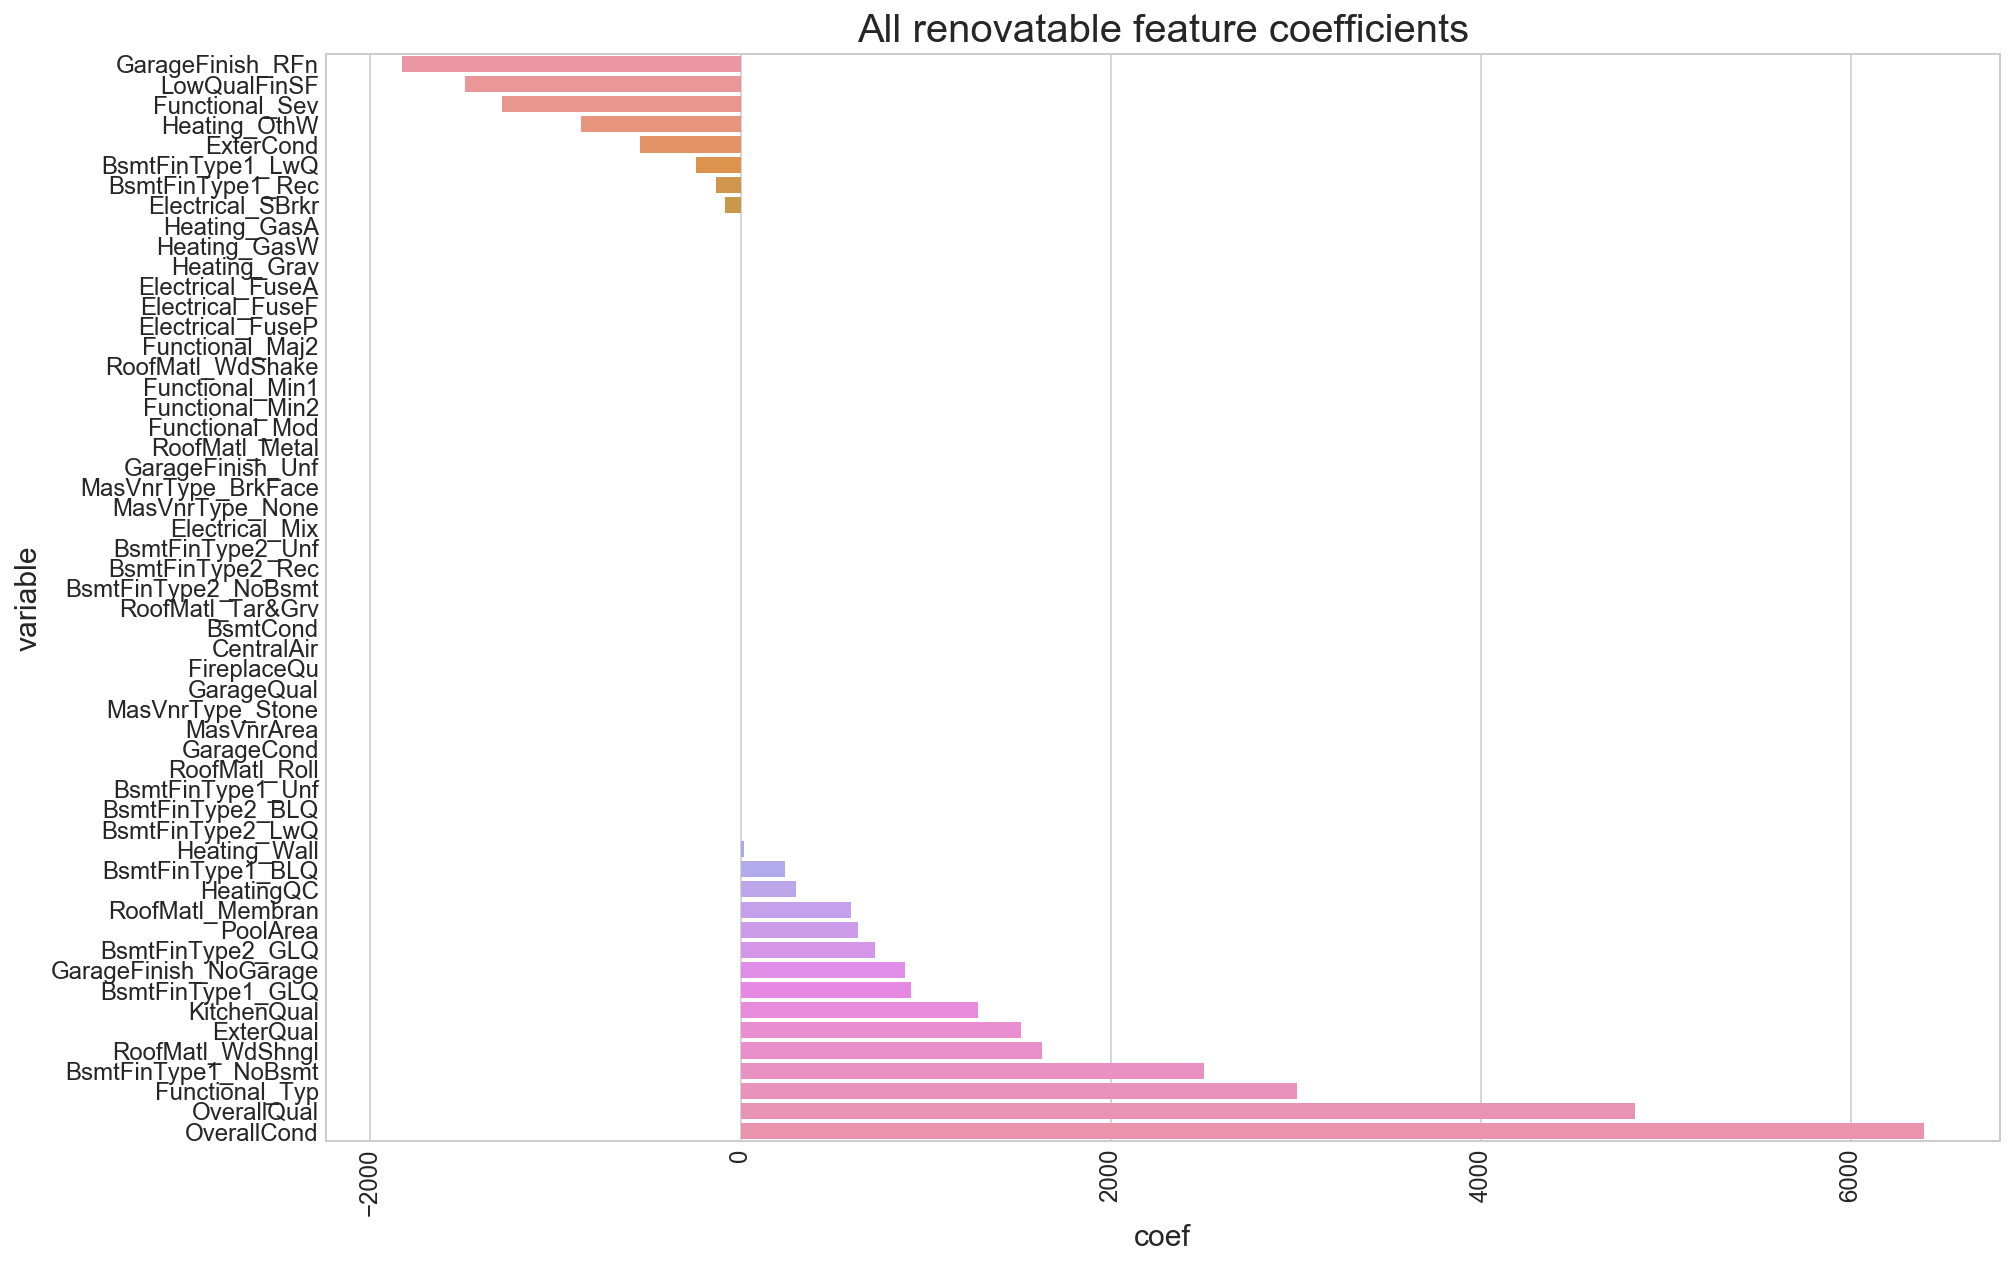

In [581]:
plt.figure(figsize=(15,10))
sns.barplot(x='coef',y='variable',data=ren_lasso_coefs.sort_values('coef'))
plt.title('All renovatable feature coefficients')
plt.xticks(rotation=90)
plt.show()

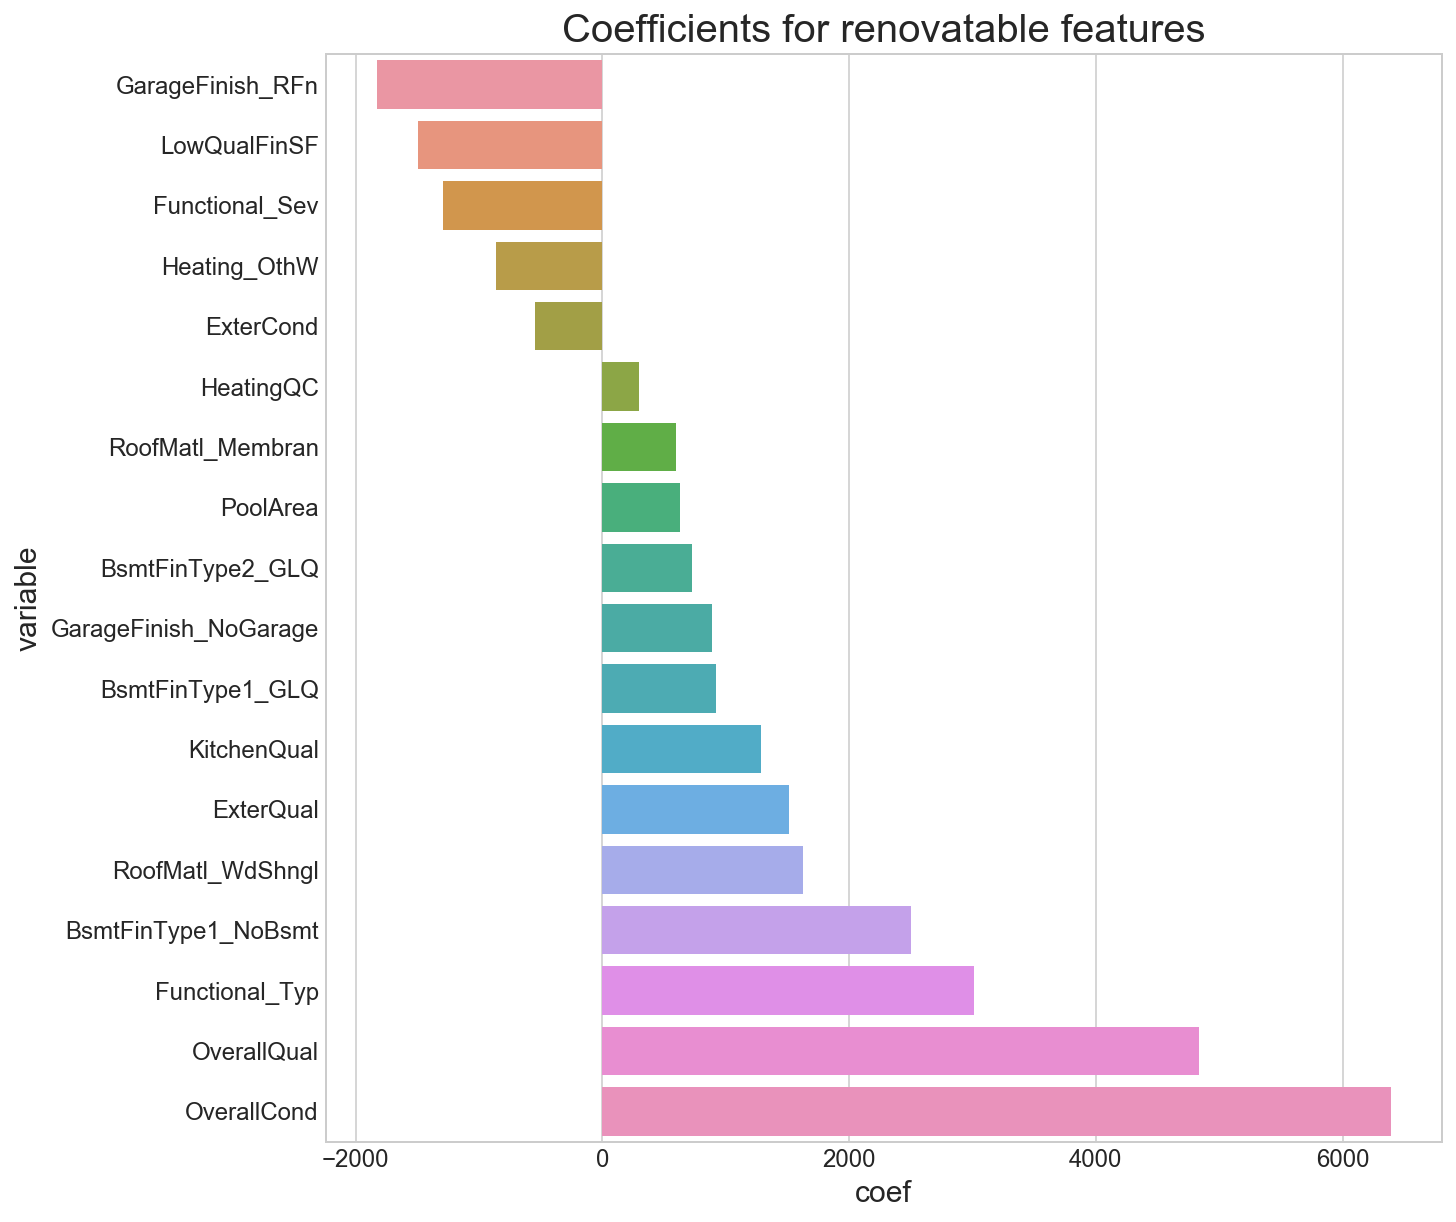

In [582]:
plt.subplots(figsize=(10,10))
sns.barplot(x='coef',y='variable', data=top_lasso.sort_values('coef'))
plt.title('Coefficients for renovatable features')
plt.show()

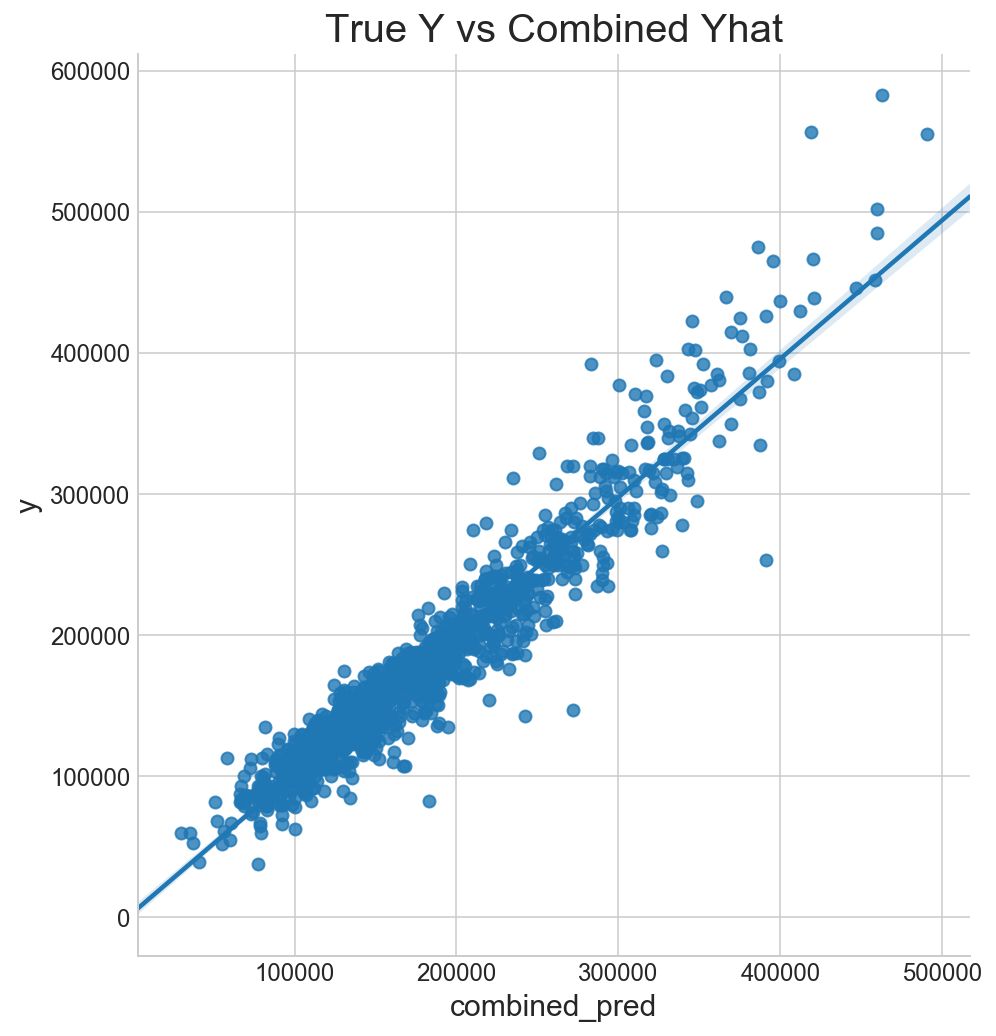

In [583]:
y_scores = list(zip(y,combined_pred))

sale_score = pd.DataFrame(y_scores, columns=['y','combined_pred'])

sns.lmplot(x="combined_pred", y="y", data=sale_score, size=7)
plt.title('True Y vs Combined Yhat')
plt.show()

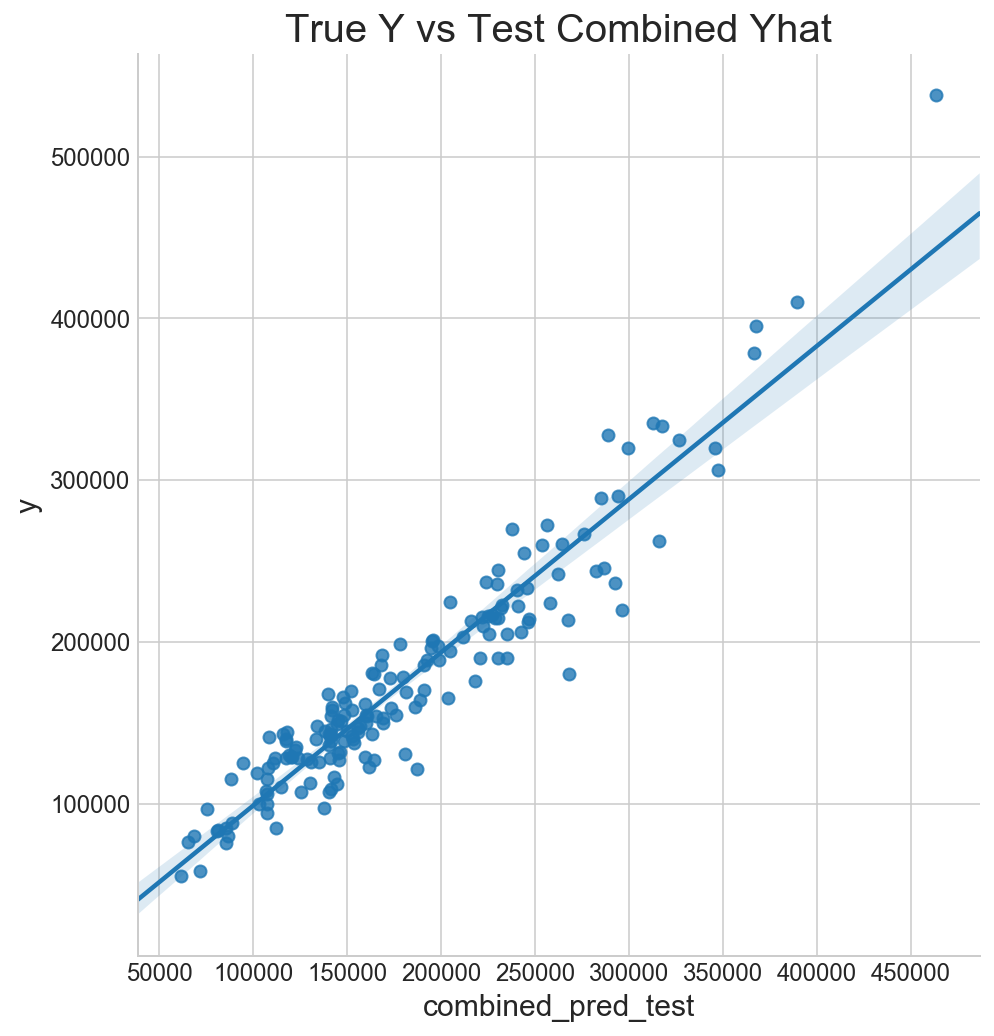

In [584]:
sale_score_test = pd.DataFrame(list(zip(y_test,combined_pred_test)), columns=['y','combined_pred_test'])

sns.lmplot(x="combined_pred_test", y="y", data=sale_score_test, size=7)
plt.title('True Y vs Test Combined Yhat')
plt.show()

### Part2 Answers

In [585]:
top_lasso

,abs_coef,coef,variable
1,6393.165219,6393.165219,OverallCond
0,4834.055226,4834.055226,OverallQual
41,3009.352658,3009.352658,Functional_Typ
17,2502.889904,2502.889904,BsmtFinType1_NoBsmt
43,1829.954517,-1829.954517,GarageFinish_RFn
53,1630.268326,1630.268326,RoofMatl_WdShngl
2,1517.337004,1517.337004,ExterQual
7,1491.152815,-1491.152815,LowQualFinSF
40,1291.211962,-1291.211962,Functional_Sev
8,1283.205243,1283.205243,KitchenQual


__Explanation__ <br>
>This table shows the price change for the increase in each feature. For example, as the Overall Condition increases(on a scale of 1-10) the house price will increase by \$6301.<br>
For categorical variables such as the Basement Finish Type 1, the model states that if there is no basement by \$2447 while if the Basement Finish Type 1 is Good Quality, the price will only increase by \$866. Though this is interesting as for our first model it has basement size as a very good predictor of house price.

__Company Evaluation__ <br>
>My company would use this second model by having it as a reference to evaluate how impactful the quality and condition various parts of the house is.  
Also we can use this to make money by checking the cost of improving the quality of areas of the house, and focusing in the parts which have the greatest profit margin. An example would be to not focus much on the garage finish and instead make sure the house has wooden shingle roof tiles.  
We can also focus efforts more into fixed features such as location and living area as they are factoring in much more of the price then the renovatable features.

In [586]:
print('R^2 fixed features:',enet_r2)
print('R^2 renovatable features:',ren_lasso_r2)
print('combined score:', combined_score )

R^2 fixed features: 0.8903049882046785
R^2 renovatable features: 0.23525231153960036
combined score: 0.9161109932938916


In [184]:
print('R^2 test data fixed features:',enet_r2_test)
print('R^2 test data renovatable features:',ren_lasso_r2_test)
print('test data combined score:', combined_score_test)

R^2 test data fixed features: 0.8745247515329992
R^2 test data renovatable features: 0.09841165083852232
test data combined score: 0.8978963520224502


__Investigation__  
> We managed to get a great R^2 score for the first model but a very low score for the second model.  
It is saying that for the test data only around 10% of the error we have for our predictions can be explained by renovatable features.  
This could be due to the small dataframe we have to test on, also it could be due to a change in the trend of houses built in 2010.  
But as the training data is stil only at 23% accuracy we can safely say that the renovatable features don't change the house price that much compared to fixed features.

__Trust?__
> I trust most of the model giving a general trend of which qualities of the house should be fixed up as some of them are common sense, as over-all quality and condition.  
Though I dont trust having no basement will be beneficial as the first model had basement size as a good predictor and also in retrospect I dont think having no basement is a renovatable feature but as its under the finish of the basement, I wouldnt know how to go about fixing that.  
So I think this model should be used as a general idea on where to focus and an estimate of the profit but they shouldn't be used as an end all model.

## Part 3

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

### EDA

In [190]:
cond_df = fixed_2_df.merge(fin_ren_df, left_index = True, right_index = True,how = 'outer')

In [191]:
cond_df.select_dtypes(include='object').columns

Index(['MSSubClass', 'Exterior1st', 'Exterior2nd', 'BsmtExposure',
       'GarageType', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'YearBuilt', 'RoofStyle'],
      dtype='object')

In [192]:
cond_obj_cols = list(cond_df.select_dtypes(include='object').columns)
dummies = pd.get_dummies(cond_df[cond_obj_cols], drop_first = True)

# Merge the dataframe result back onto the original dataframe
cond_2_df = cond_df.merge(dummies, left_index = True, right_index = True,how = 'outer')

In [193]:
cond_2_df = cond_2_df.drop(cond_obj_cols, axis = 1)

In [194]:
cond_2_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1443 entries, 0 to 1459
Columns: 286 entries, LotArea to RoofStyle_Shed
dtypes: float64(6), int64(22), uint8(258)
memory usage: 730.5 KB


In [195]:
cond_3_df = cond_2_df.merge(house[['SalePrice','SaleCondition','SaleType']], left_index = True, right_index = True,how = 'outer')

In [196]:
cond_2_df.select_dtypes(include='object').columns

Index([], dtype='object')

In [197]:
house.shape

(1443, 81)

In [198]:
fixed_2_df.shape

(1443, 24)

In [199]:
cond_3_df['SaleCondition'].value_counts()

Normal     1192
Partial     121
Abnorml      95
Family       20
Alloca       11
AdjLand       4
Name: SaleCondition, dtype: int64

In [200]:
cond_3_df['SaleType'].value_counts()

WD       1258
New       118
COD        41
ConLD       7
ConLw       5
ConLI       5
CWD         4
Oth         3
Con         2
Name: SaleType, dtype: int64

In [201]:
# sns.swarmplot(x='SaleCondition',y='SalePrice',hue='SaleType', data=cond_2_df)

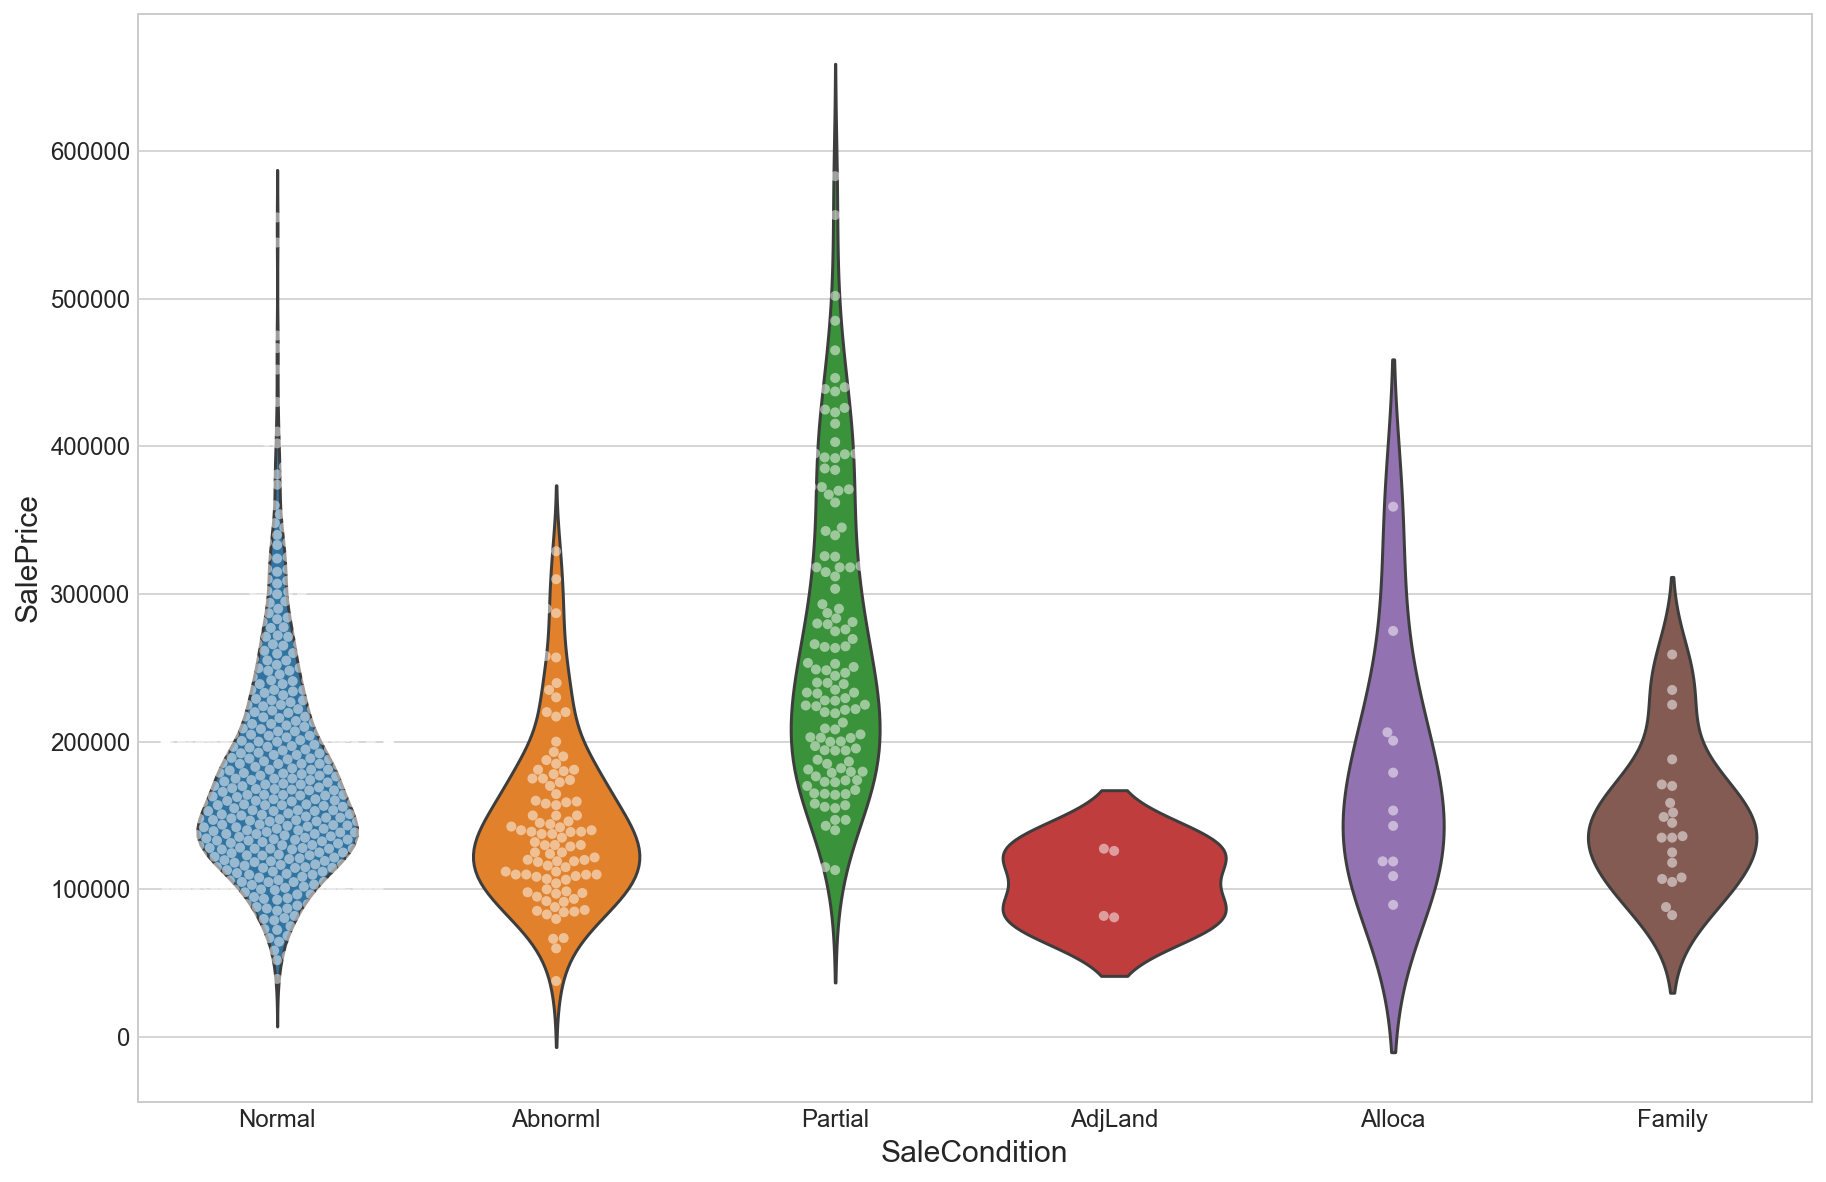

In [202]:
sns.violinplot(x=cond_3_df['SaleCondition'], y=cond_3_df['SalePrice'], inner=None)
sns.swarmplot(x=cond_3_df['SaleCondition'], y=cond_3_df['SalePrice'], color='w', alpha=.5)


In [203]:
cond_to_replace = {'Normal':0,'Partial':0,'AdjLand':0,'Alloca':0,'Family':0,'Abnorml':1}

In [204]:
cond_3_df.replace(cond_to_replace, inplace=True)

### Modeling

In [365]:
CX = cond_3_df.copy()
Cy = cond_3_df['SaleCondition'].values

In [366]:
CX.drop(columns = ['SaleCondition','SaleType'], inplace=True)

In [367]:
CX_train, CX_test, Cy_train, Cy_test = train_test_split(CX, Cy, test_size=0.30)

In [368]:
CXs = ss.fit_transform(CX_train)
CXs_test = ss.fit_transform(CX_test)

#### Logistic Regression

In [369]:
logregCV = LogisticRegressionCV()
logreg = LogisticRegression()

In [370]:
logreg.fit(CX_train,Cy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [372]:
logreg_scores

array([0.85148515, 0.81188119, 0.82178218, 0.82178218, 0.84158416,
       0.86138614, 0.86138614, 0.88118812, 0.86138614, 0.9009901 ])

In [373]:
logreg.intercept_

array([-1.83862274e-07])

In [374]:
logreg.predict_proba(CXs)

array([[0.49988335, 0.50011665],
       [0.49967433, 0.50032567],
       [0.5000352 , 0.4999648 ],
       ...,
       [0.4999732 , 0.5000268 ],
       [0.50035068, 0.49964932],
       [0.49988859, 0.50011141]])

In [375]:
logreg.score(CXs_test,Cy_test)

0.5565819861431871

In [376]:
Cy_pred = logreg.predict(CXs)
Cy_pred_test = logreg.predict(CX_test)

In [400]:
confusion_matrix(Cy_train, Cy_pred)

array([[550, 390],
       [ 37,  33]], dtype=int64)

#### SVM

In [379]:
clf.fit(CXs,Cy_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [380]:
Cy_pred_clf = clf.predict(CXs)
Cy_pred_clf_test = clf.predict(CXs_test)

In [381]:
recall_score(Cy_train, Cy_pred_clf)

0.08571428571428572

In [382]:
confusion_matrix(Cy_train, Cy_pred_clf)

array([[940,   0],
       [ 64,   6]], dtype=int64)

In [383]:
confusion_matrix(Cy_test, Cy_pred_clf_test)

array([[408,   0],
       [ 25,   0]], dtype=int64)

#### SVM Grid Search -- Slow

In [384]:
# clf = svm.SVC()

# gamma_range = np.logspace(-5, 2, 10)
# C_range = np.logspace(-3, 2, 10)
# kernel_range = ['rbf', 'sigmoid', 'linear', 'poly']

# param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

# grid = GridSearchCV(clf, param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)
# grid.fit(CXs, Cy_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    5.7s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   13.6s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   26.4s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   43.2s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': array([1.00000e-05, 5.99484e-05, 3.59381e-04, 2.15443e-03, 1.29155e-02,
       7.74264e-02, 4.64159e-01, 2.78256e+00, 1.66810e+01, 1.00000e+02]), 'C': array([1.00000e-03, 3.59381e-03, 1.29155e-02, 4.64159e-02, 1.66810e-01,
       5.99484e-01, 2.15443e+00, 7.74264e+00, 2.78256e+01, 1.00000e+02]), 'kernel': ['rbf', 'sigmoid', 'linear', 'poly']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [613]:
# Made smaller gridsearch knowing the best parameters to save processing time
# Using a scoring of recall to stop the model from scoring on accuracy as accuracy is counting false positives

clf = svm.SVC()

gamma_range = np.logspace(0, 1, 10)
C_range = np.logspace(0, 2, 10)
kernel_range = ['linear']

param_grid = dict(gamma=gamma_range, C=C_range, kernel=kernel_range)

grid = GridSearchCV(clf, param_grid, cv=3, scoring='recall', verbose=1, n_jobs=-1)
grid.fit(CXs, Cy_train)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:   20.5s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   30.9s finished


GridSearchCV(cv=3, error_score='raise',
       estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'gamma': array([ 1.     ,  1.12884,  1.27427,  1.43845,  1.62378,  1.83298,
        2.06914,  2.33572,  2.63665,  2.97635,  3.35982,  3.79269,
        4.28133,  4.83293,  5.45559,  6.15848,  6.95193,  7.8476 ,
        8.85867, 10.     ]), 'C': array([  1.     ,   1.27427,   1.62378,   2....21,  29.76351,  37.9269 ,  48.3293 ,  61.58482,
        78.476  , 100.     ]), 'kernel': ['linear']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='recall', verbose=1)

In [615]:
print(grid.best_params_)
print(grid.best_score_)

{'C': 1.0, 'gamma': 1.0, 'kernel': 'linear'}
0.1591046061127852


In [616]:
best_svm = grid.best_estimator_

In [617]:
best_svm.fit(CXs,Cy_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1.0, kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [618]:
Cy_pred_svm = best_svm.predict(CXs)
Cy_pred_svm_test = best_svm.predict(CXs_test)

In [619]:
confusion_matrix(Cy_train, Cy_pred_svm)

array([[940,   0],
       [ 21,  49]], dtype=int64)

In [620]:
confusion_matrix(Cy_test, Cy_pred_svm_test)

array([[367,  41],
       [ 21,   4]], dtype=int64)

In [621]:
print(classification_report(Cy_train, Cy_pred_svm))

             precision    recall  f1-score   support

          0       0.98      1.00      0.99       940
          1       1.00      0.70      0.82        70

avg / total       0.98      0.98      0.98      1010



In [612]:
svm_coef = best_svm.coef_

In [394]:
svm_coef = svm_coef.ravel()

In [395]:
svm_coef.shape

(287,)

In [396]:
svm_coefs_df = pd.DataFrame({'variable':CX.columns,
                            'coef':svm_coef,
                            'abs_coef':np.abs(svm_coef)})

svm_coefs_df.sort_values('abs_coef', inplace=True, ascending=False)

### Part3 Answers

In [626]:
svm_coefs_df.head(10)

,abs_coef,coef,variable
4,0.892133,0.892133,GrLivArea
55,0.695355,0.695355,Functional_Typ
12,0.684024,0.684024,OverallQual
115,0.674511,-0.674511,GarageType_Attchd
5,0.634401,-0.634401,FullBath
60,0.615749,-0.615749,MasVnrType_None
119,0.600407,-0.600407,GarageType_Detchd
165,0.581105,0.581105,HouseStyle_1Story
286,0.557608,-0.557608,SalePrice
24,0.557608,-0.557608,SalePrice_y


__Analysis__
> I dont know if I did this correctly but we can see that the top predictors of an abnormal sale is living area, typical house(no damages). With an attached garage, number of full baths and no massonry reduces the change for it to be an abnormal sale.

> It is overfitting on training data and also because of class inbalance, there is a lot of false postives which is why I am using recall to score it.

In [624]:
recall_score(Cy_train,Cy_pred_svm)

0.7

In [625]:
recall_score(Cy_test,Cy_pred_svm_test)

0.16